In [1]:
# imports

import os
import pprint
import pickle
import glob
import json
import re
import string
import datetime
from datetime import timezone
import scipy
from scipy import stats

from collections import defaultdict

import nltk
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
from nltk.util import ngrams

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np

In [2]:
# utility objects

MILLISEC_PER_MONTH = 1000 * 60 * 60 * 24 * 30

pp = pprint.PrettyPrinter(indent=4)
def print_term_to_senders():
    pp.pprint(term_to_senders)
    
standard_contractions = set(["aren't", "can't", "could've", "couldn't", "didn't", 
            "doesn't", "don't", "hadn't", "hasn't", "haven't", "he'd", "he'll", "he's", 
            "how'd", "how'll", "how's", "i'd", "i'll", "i'm", "i've", "isn't", "it'd", 
            "it'll", "it's", "let's", "might've", "mightn't", "must've", 
            "mustn't", "needn't", "o'clock", "she'd", "she'll", "she's", 
            "should've", "shouldn't", "that'd", "that's", "there'd", 
            "there's", "they'd", "they'll", "they're", "they've", "wasn't", 
            "we'd", "we'll", "we're", "we've", "weren't", "what'll", "what're", "what's",
            "what've", "when's", "when've", "where'd", "where's", "where've", "who'll", 
            "who's", "who've", "why's", "won't", "would've", 
            "wouldn't", "you'd", "you'll", "you're", "you've"])

# add in all contractions without the apostrophes also
new_contractions = set()
for contraction in standard_contractions:
    new_contractions.add(contraction.replace("'", ""))

standard_contractions = standard_contractions.union(new_contractions)

def get_wordnet_pos(word):
    """Map POS tag to first character lemmatize() accepts"""
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}

    return tag_dict.get(tag, wordnet.NOUN)
lemmatizer = WordNetLemmatizer()

In [3]:
# helper functions

def preprocess(words):
    words = words.lower()
    # weird thing with apostrophe showing up as this unicode string
    words = re.sub("\u00e2\u0080\u0099", "'", words)
    # filter out all remaining Unicode, TODO: maybe want to translate these into emojis?
    words = words.encode("ascii", "ignore").decode("UTF-8")
    return words

def print_sorted_dict(d, first_x=None):
    sorted_keys = sorted(d, key=d.get, reverse=True)
    for i, key in enumerate(sorted_keys):
        if first_x is not None and i >= first_x:
            break
        print(f"Rank {i+1}:", key, d[key])
    return sorted_keys

def is_contraction(word):
    if "'" in word:
        split_word = word.split("'")
        if len(split_word) > 1 and split_word[0] in english_words:
            return True
    return False

terms_to_include = set(["kys"])
def exclude_word(word):
    return (len(word) < 1 or word in english_words or word.isdigit() 
            or is_contraction(word) or word in standard_contractions) and (word not in terms_to_include)

In [10]:
pickled_dict_fname = "term_to_senders_dict"
term_to_senders = pickle.load(open(pickled_dict_fname, "rb")) 

# {
#     "<term>": {
#         "<friend_name>": 
#             {
#                  "<friend_name>": [<list of timestamps in ms>],
#                  "<account_user_name>": [<list of timestamps in ms>]
#             }
#         ....
#     },
#     ....
# }

# FILTER term_to_senders, 
# TODO: sort by occurrence, and see the cutoff filtering based on something besides frequency

import copy
term_to_senders_original = copy.deepcopy(term_to_senders)

# term_to_senders schema
# {
#     "<term>": {
#         "<friend_name>": 
#             {
#                  "<friend_name>": [<list of timestamps in ms>],
#                  "<account_user_name>": [<list of timestamps in ms>]
#             }
#         ....
#     },
#     ....
# }

term_to_senders = copy.deepcopy(term_to_senders_original)
terms_to_delete = set()
term_to_count = defaultdict(lambda: 0)
sender_to_term_count = defaultdict(lambda: defaultdict(lambda: 0))
# {
#   "<user_name>"": {
#     "<term>": count,
#     ...
#   }
# }

for term in term_to_senders:
    num_usages = 0
    for friend_name in term_to_senders[term]:
        # count up usages for both user and friends
        for user_name in term_to_senders[term][friend_name]:
            timestamp_count = len(term_to_senders[term][friend_name][user_name])
            num_usages += timestamp_count
            sender_to_term_count[user_name][term] += timestamp_count
    if num_usages < 4:
        terms_to_delete.add(term)
    else:
        term_to_count[term] += num_usages
    for sender in sender_to_term_count:
        try:
            if sender_to_term_count[sender][term] < 4:
                del sender_to_term_count[sender][term]
        except KeyError:
            pass
for term in terms_to_delete:
     del term_to_senders[term]
print(len(term_to_senders)) # should be 9998

# prints slang ranked by frequency for a single user
friend_name = "Dan J Chong"
freq_per_friend = print_sorted_dict(sender_to_term_count[friend_name])

9998
Rank 1: lol 1242
Rank 2: fuck 454
Rank 3: ok 401
Rank 4: shit 263
Rank 5: pm 263
Rank 6: 2/15/16 258
Rank 7: ('pm', 'paschal') 258
Rank 8: gonna 237
Rank 9: wanna 151
Rank 10: wtf 148
Rank 11: lmao 130
Rank 12: kid 127
Rank 13: okay 125
Rank 14: idk 124
Rank 15: btw 117
Rank 16: nah 110
Rank 17: teh 103
Rank 18: lawrence 102
Rank 19: lmfao 100
Rank 20: xd 90
Rank 21: aditya 86
Rank 22: ('im', 'gonna') 80
Rank 23: rofl 75
Rank 24: ('lol', 'i') 62
Rank 25: email 57
Rank 26: mom 56
Rank 27: fk 55
Rank 28: addy 54
Rank 29: kinda 53
Rank 30: avi 53
Rank 31: ('holy', 'shit') 52
Rank 32: spanish 52
Rank 33: ahve 52
Rank 34: ('the', 'fuck') 51
Rank 35: rutgers 51
Rank 36: jsut 51
Rank 37: liek 51
Rank 38: korean 50
Rank 39: hte 48
Rank 40: hw 45
Rank 41: pls 44
Rank 42: kys 43
Rank 43: ('oh', 'shit') 41
Rank 44: haha 41
Rank 45: fuckign 41
Rank 46: km 40
Rank 47: jk 37
Rank 48: ('you', 'guys') 36
Rank 49: omg 35
Rank 50: ('wanted', 'to') 35
Rank 51: bro 34
Rank 52: woudl 34
Rank 53: hang 

Rank 755: congrats 4
Rank 756: ('months', 'ago') 4
Rank 757: ('you', 'missed') 4
Rank 758: ('missed', 'a') 4
Rank 759: depends 4
Rank 760: ('its', 'gonna') 4
Rank 761: ('this', 'kid') 4
Rank 762: ('kids', 'are') 4
Rank 763: ('nah', "it's") 4
Rank 764: 9th 4
Rank 765: cafe 4
Rank 766: ('she', 'wanted') 4
Rank 767: ('mom', 'is') 4
Rank 768: ('a', 'kid') 4
Rank 769: szalecki 4
Rank 770: ('but', 'idk') 4
Rank 771: smh 4
Rank 772: ("it's", 'kinda') 4
Rank 773: ('has', 'it') 4
Rank 774: ('have', 'internet') 4
Rank 775: 7th 4
Rank 776: 8th 4
Rank 777: ('an', 'asshole') 4
Rank 778: ('from', 'eb') 4
Rank 779: ('the', 'ones') 4
Rank 780: jfc 4
Rank 781: washington 4
Rank 782: ('it', 'takes') 4
Rank 783: ther 4
Rank 784: ('for', 'fucking') 4
Rank 785: ('be', 'friends') 4
Rank 786: ('intro', 'to') 4
Rank 787: amazon 4
Rank 788: cmon 4
Rank 789: ('called', 'you') 4
Rank 790: matlab 4
Rank 791: ('ok', 'ill') 4
Rank 792: ('with', 'tina') 4
Rank 793: ('shit', 'out') 4
Rank 794: outta 4
Rank 795: ('btw

In [5]:
# define terms for analysis
msg_dir = "/home/lhuang21/Documents/SideProjects/Grapevine/facebook-lawrenceh1850/messages/inbox"
account_user_name = "Lawrence Huang"
# terms where I influenced friend
# TERM = "wtf"
# TERM = "okay"

# 0 correlation
# TERM = "lol"
# TERM = "ok"

# terms where friend influenced me
# TERM = ("holy", "shit")
TERM = ("shit")
# TERM = ("lmao")
# TERM = ("xd")
FRIEND_NAME = "Dan J Chong"

In [6]:
# calculate moving average

def term_freq_avg(start_time_milli, end_time_milli, term, friend_name, msg_dir):
    """
    Calculates average term frequency per word in a given time frame for all users involved in conversation.
    """
    if start_time_milli > end_time_milli:
        raise ValueError("End time must be after start time.")
    
    dir_prefix = friend_name.strip().replace(" ", "").lower()
    msg_file_path = os.path.join(msg_dir, dir_prefix + "*")
    candidate_dirs = glob.glob(msg_file_path)
    
    # this is for determining whether the term is a single word
    # bigram or trigram
    term_dimension = 1
    if isinstance(term, tuple):
        term_dimension = len(term)
    
    if len(candidate_dirs) != 1:
        raise ValueError("Invalid path for friend name and message directory specified")
    else:
        msg_file_path = os.path.join(candidate_dirs[0], "message_1.json") 
        
        # make sure file exists
        if not os.path.exists(msg_file_path):
            raise ValueError(f"{msg_file_path} doesn't exist")
        else:
            json_dict = json.load(open(msg_file_path, 'r'))

            word_count_in_period = {}
            term_count_in_period = {}
            
            for name_dict in json_dict["participants"]:
                participant_name = name_dict["name"]
                term_count_in_period[participant_name] = 0
                word_count_in_period[participant_name] = 0

            for index, msg in enumerate(reversed(json_dict['messages'])):
                msg_timestamp_ms = msg["timestamp_ms"]
                sender = msg["sender_name"]
                
                if msg_timestamp_ms >= start_time_milli:
                    if msg_timestamp_ms > end_time_milli:
                        break
                    
                    try:
                        content = preprocess(msg["content"])
                    except KeyError:
                        # in case there isn't a content key
                        continue
                    tok_content = content.split()
                    
                    word_count_in_period[sender] += len(tok_content)
                    
                    if term_dimension == 1:
                        # monograms
                        for word in tok_content:
                            word = word.strip(string.punctuation)
                            if len(word) > 0:
                                # only lemmatize if this was not a hand-picked word
                                if word not in terms_to_include:
                                    word = lemmatizer.lemmatize(word, get_wordnet_pos(word))
                                if word == term:
                                    term_count_in_period[sender] += 1
                    elif term_dimension == 2:
                        # bigrams
                        for (tok1, tok2) in ngrams(tok_content, 2):
                            tok1 = tok1.strip(string.punctuation)
                            tok2 = tok2.strip(string.punctuation)
                            if term == (tok1, tok2):
                                term_count_in_period[sender] += 1
                    elif term_dimension == 3:
                        # trigrams
                        for (tok1, tok2, tok3) in ngrams(tok_content, 3):
                            tok1 = tok1.strip(string.punctuation)
                            tok2 = tok2.strip(string.punctuation)
                            tok3 = tok3.strip(string.punctuation)
                            if term == (tok1, tok2, tok3):
                                term_count_in_period[sender] += 1
                    else:
                        raise ValueError(f"Term has invalid input dimension")
                        
            for sender in term_count_in_period:
                if word_count_in_period[sender] != 0:
                    term_count_in_period[sender] /= float(word_count_in_period[sender])
                else:
                    # sender had no words in this period
                    term_count_in_period[sender] = 0
                
            return term_count_in_period

Influence score: 1.1292383342271102
A positive influence score means you influenced the other person.
    (aka your usage rate was initially higher than the other person)

    A negative influence score the other person influenced you.
    (aka your usage rate was initially lower than the other person)


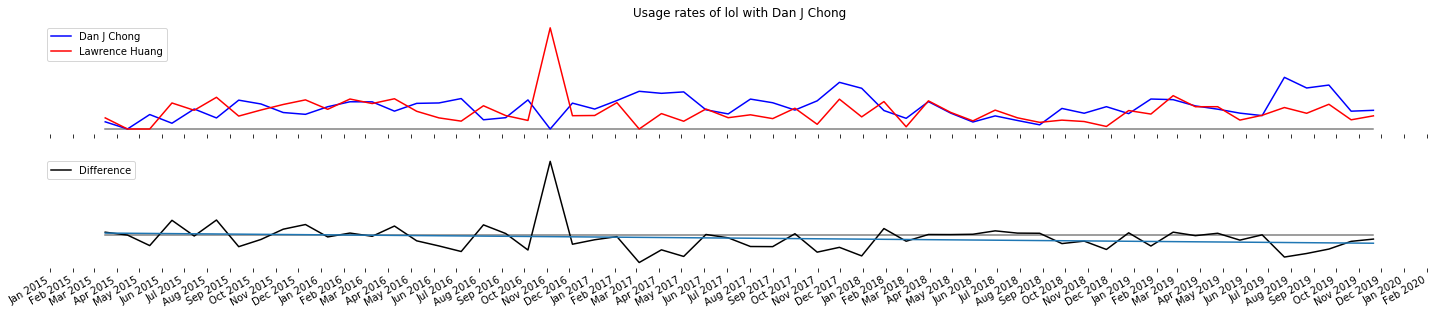

Influence score: -0.13654413072301236
A positive influence score means you influenced the other person.
    (aka your usage rate was initially higher than the other person)

    A negative influence score the other person influenced you.
    (aka your usage rate was initially lower than the other person)


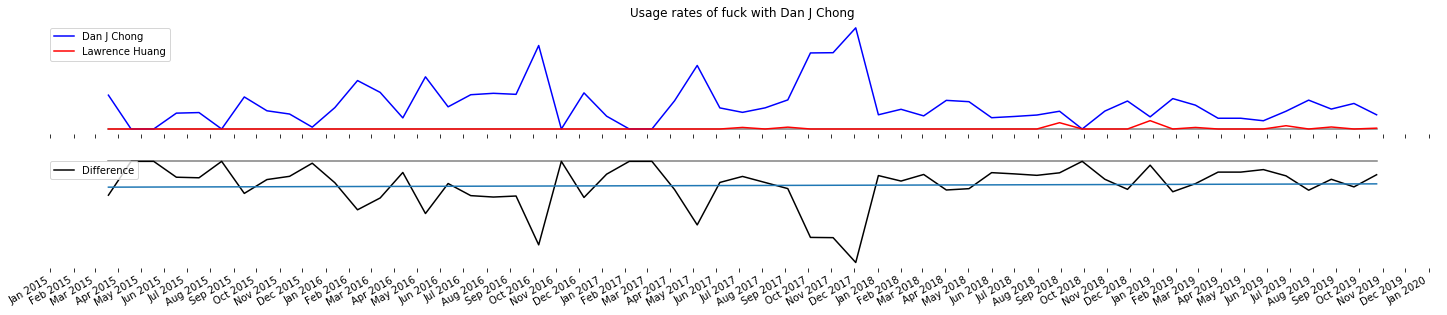

Influence score: -1.349471151571958
A positive influence score means you influenced the other person.
    (aka your usage rate was initially higher than the other person)

    A negative influence score the other person influenced you.
    (aka your usage rate was initially lower than the other person)


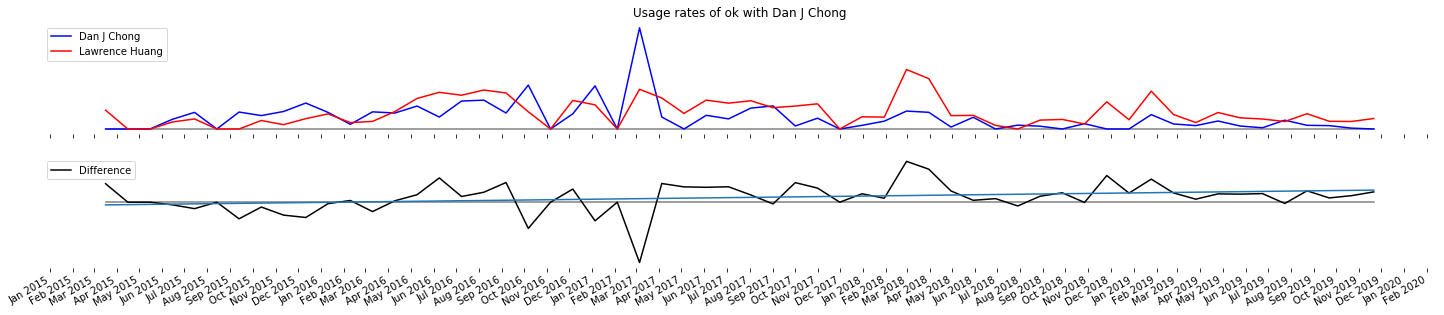

Influence score: -1.799232072051616
A positive influence score means you influenced the other person.
    (aka your usage rate was initially higher than the other person)

    A negative influence score the other person influenced you.
    (aka your usage rate was initially lower than the other person)


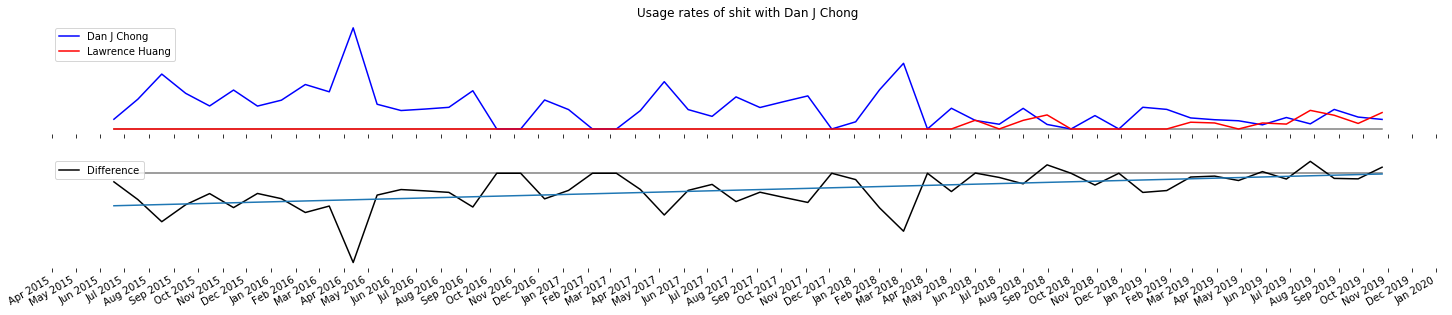

Influence score: -0.9946463565098768
A positive influence score means you influenced the other person.
    (aka your usage rate was initially higher than the other person)

    A negative influence score the other person influenced you.
    (aka your usage rate was initially lower than the other person)


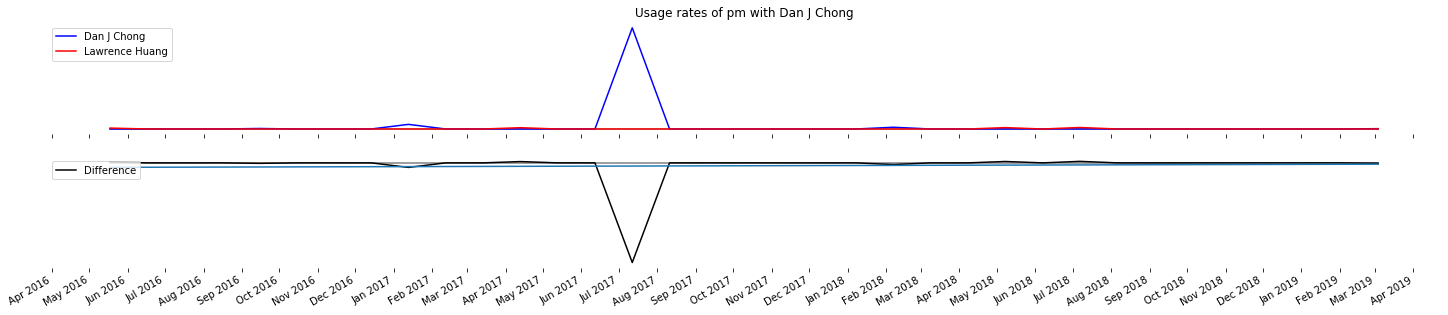

/home/lhuang21/.pyenv/versions/grapevine/lib/python3.7/site-packages/scipy/stats/_stats_mstats_common.py:130: RuntimeWarning: invalid value encountered in double_scalars
  slope = r_num / ssxm
/home/lhuang21/.pyenv/versions/grapevine/lib/python3.7/site-packages/scipy/stats/_stats_mstats_common.py:140: RuntimeWarning: invalid value encountered in sqrt
  t = r * np.sqrt(df / ((1.0 - r + TINY)*(1.0 + r + TINY)))
/home/lhuang21/.pyenv/versions/grapevine/lib/python3.7/site-packages/scipy/stats/_stats_mstats_common.py:142: RuntimeWarning: invalid value encountered in double_scalars
  sterrest = np.sqrt((1 - r**2) * ssym / ssxm / df)


Influence score: nan
A positive influence score means you influenced the other person.
    (aka your usage rate was initially higher than the other person)

    A negative influence score the other person influenced you.
    (aka your usage rate was initially lower than the other person)


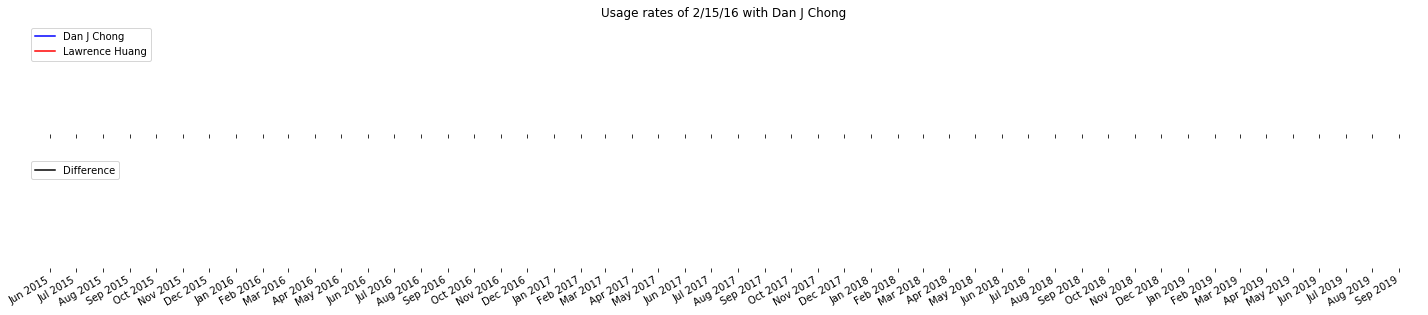

Influence score: nan
A positive influence score means you influenced the other person.
    (aka your usage rate was initially higher than the other person)

    A negative influence score the other person influenced you.
    (aka your usage rate was initially lower than the other person)


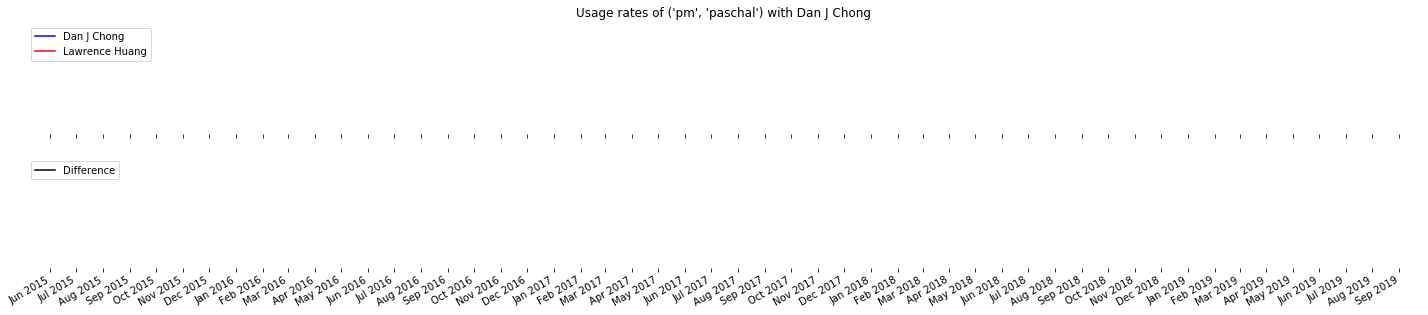

Influence score: -0.5213200644933775
A positive influence score means you influenced the other person.
    (aka your usage rate was initially higher than the other person)

    A negative influence score the other person influenced you.
    (aka your usage rate was initially lower than the other person)


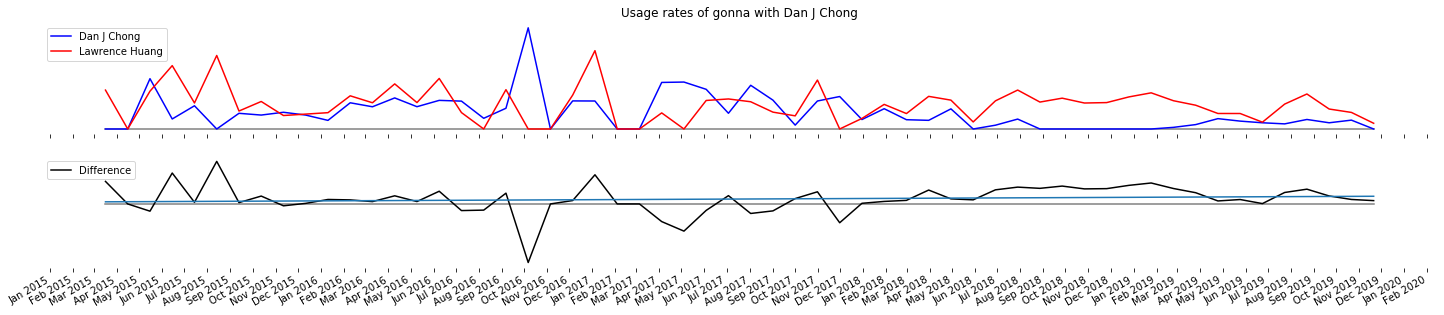

Influence score: -0.4440280001232119
A positive influence score means you influenced the other person.
    (aka your usage rate was initially higher than the other person)

    A negative influence score the other person influenced you.
    (aka your usage rate was initially lower than the other person)


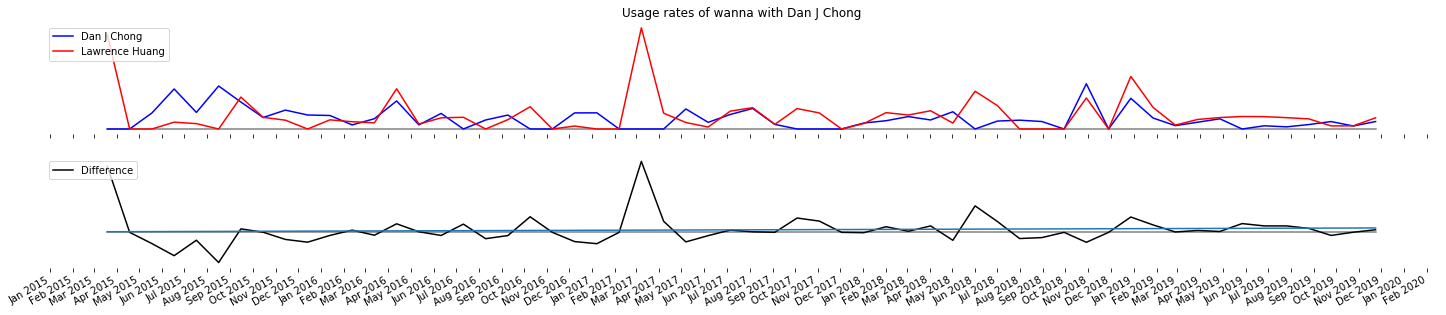

Influence score: -2.229684987154584
A positive influence score means you influenced the other person.
    (aka your usage rate was initially higher than the other person)

    A negative influence score the other person influenced you.
    (aka your usage rate was initially lower than the other person)


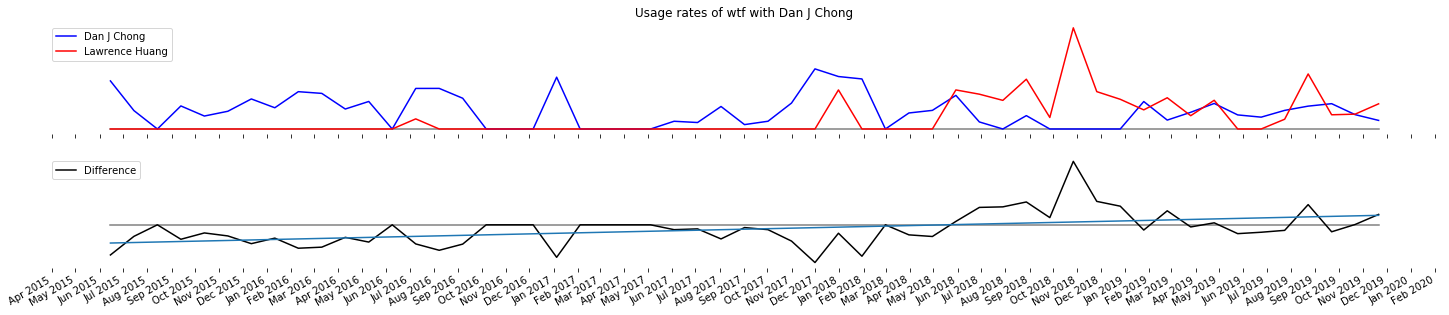

Influence score: -1.3227518581355755
A positive influence score means you influenced the other person.
    (aka your usage rate was initially higher than the other person)

    A negative influence score the other person influenced you.
    (aka your usage rate was initially lower than the other person)


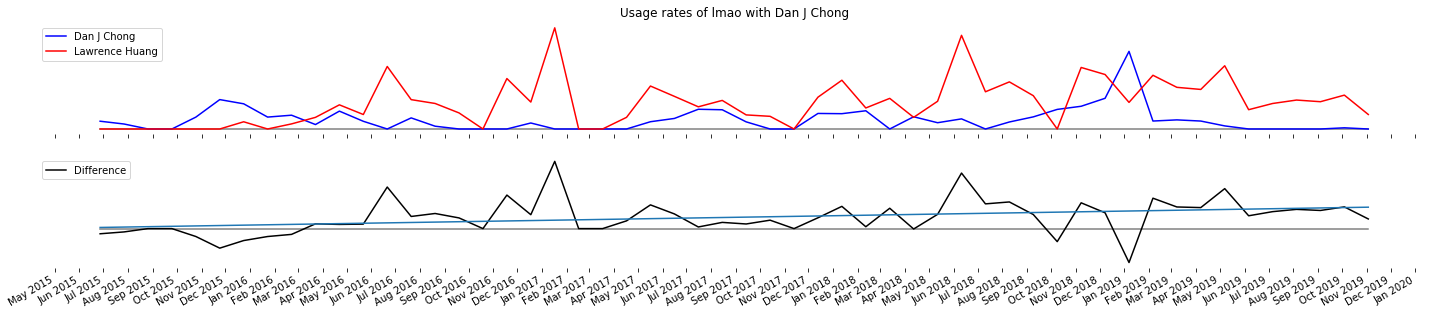

Influence score: -2.278087561869971
A positive influence score means you influenced the other person.
    (aka your usage rate was initially higher than the other person)

    A negative influence score the other person influenced you.
    (aka your usage rate was initially lower than the other person)


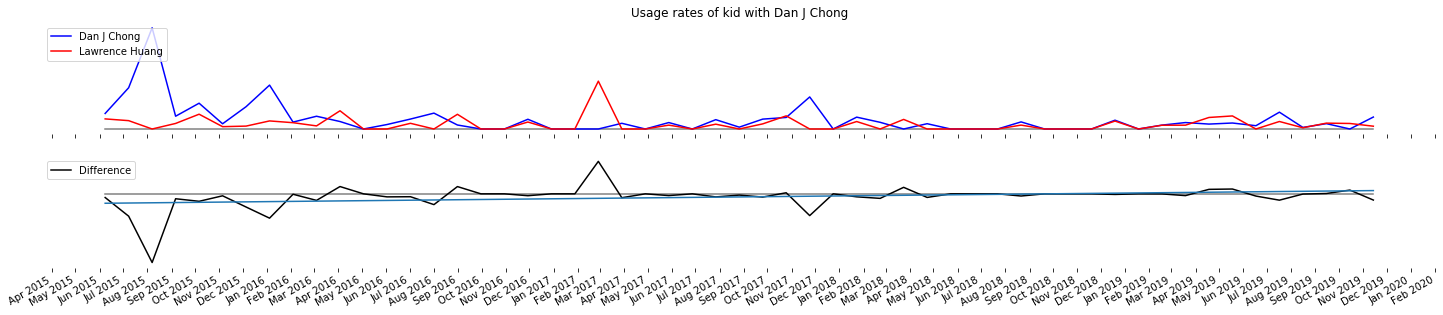

Influence score: 1.671540958040784
A positive influence score means you influenced the other person.
    (aka your usage rate was initially higher than the other person)

    A negative influence score the other person influenced you.
    (aka your usage rate was initially lower than the other person)


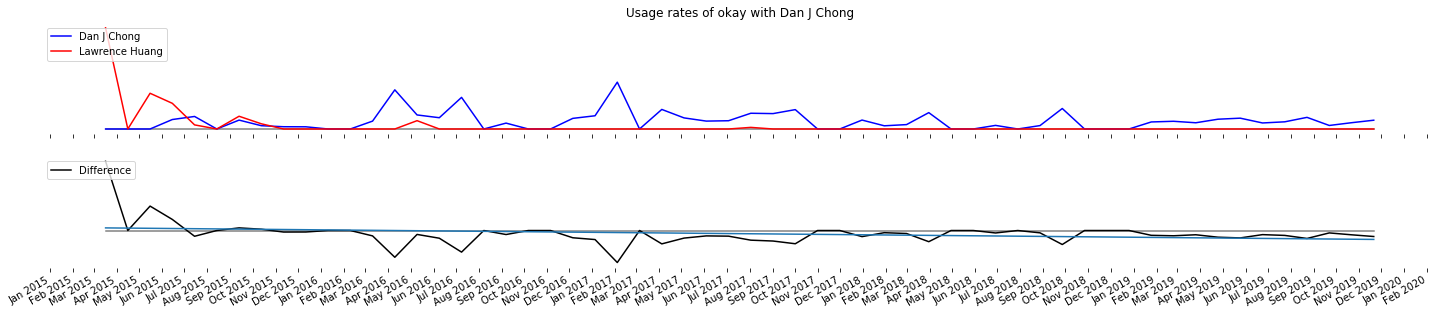

Influence score: 1.004564255232765
A positive influence score means you influenced the other person.
    (aka your usage rate was initially higher than the other person)

    A negative influence score the other person influenced you.
    (aka your usage rate was initially lower than the other person)


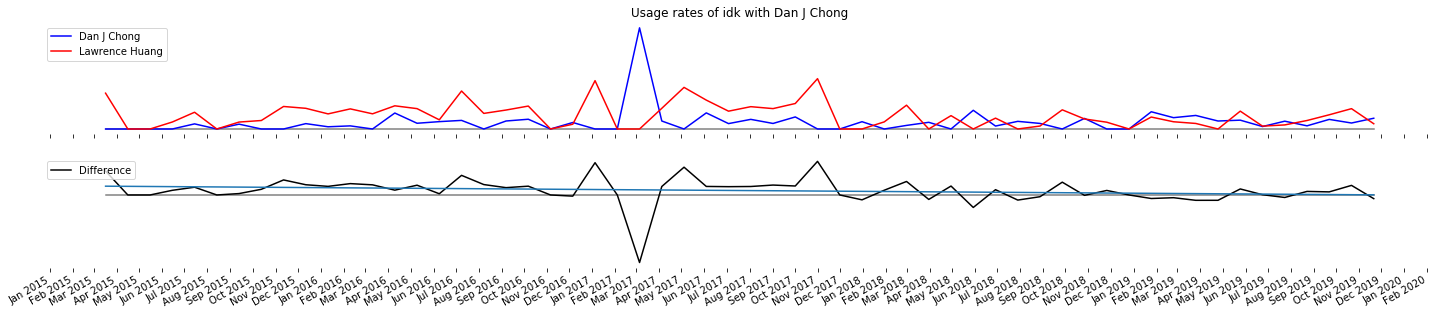

Influence score: -0.5841283923039104
A positive influence score means you influenced the other person.
    (aka your usage rate was initially higher than the other person)

    A negative influence score the other person influenced you.
    (aka your usage rate was initially lower than the other person)


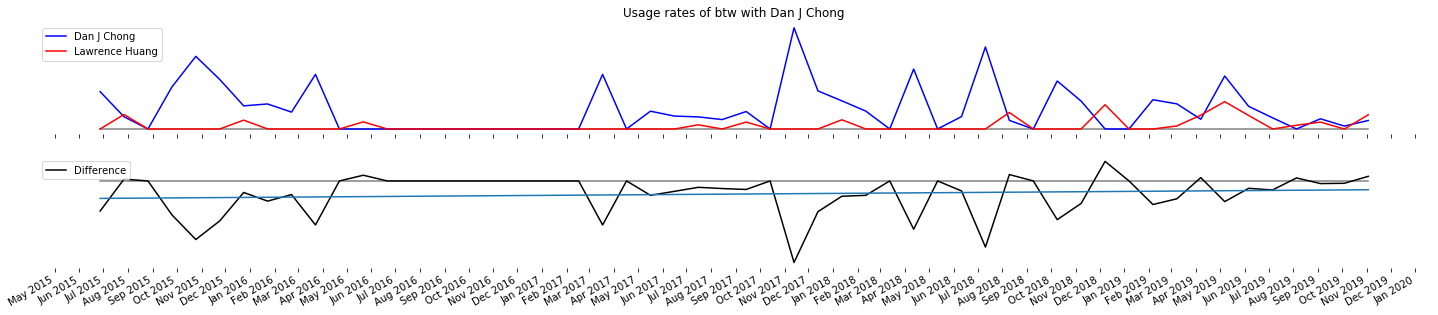

Influence score: 0.2618413755909505
A positive influence score means you influenced the other person.
    (aka your usage rate was initially higher than the other person)

    A negative influence score the other person influenced you.
    (aka your usage rate was initially lower than the other person)


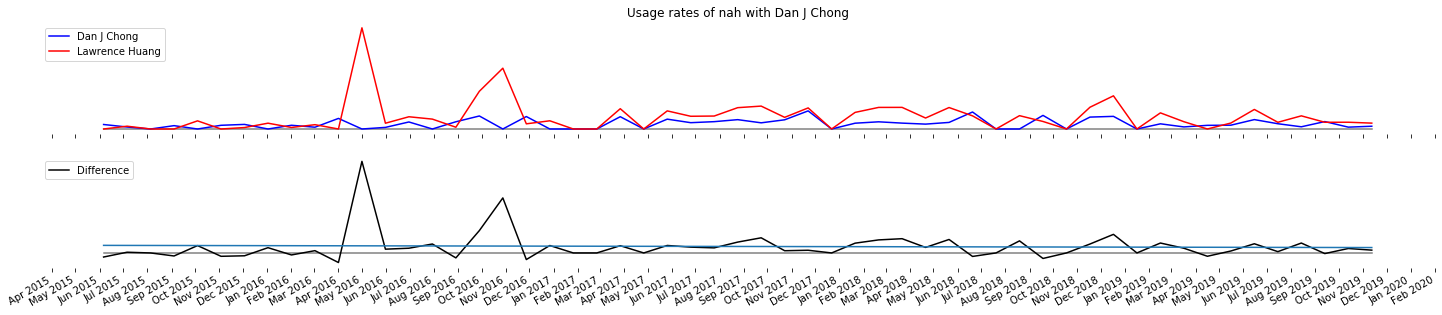

Influence score: nan
A positive influence score means you influenced the other person.
    (aka your usage rate was initially higher than the other person)

    A negative influence score the other person influenced you.
    (aka your usage rate was initially lower than the other person)


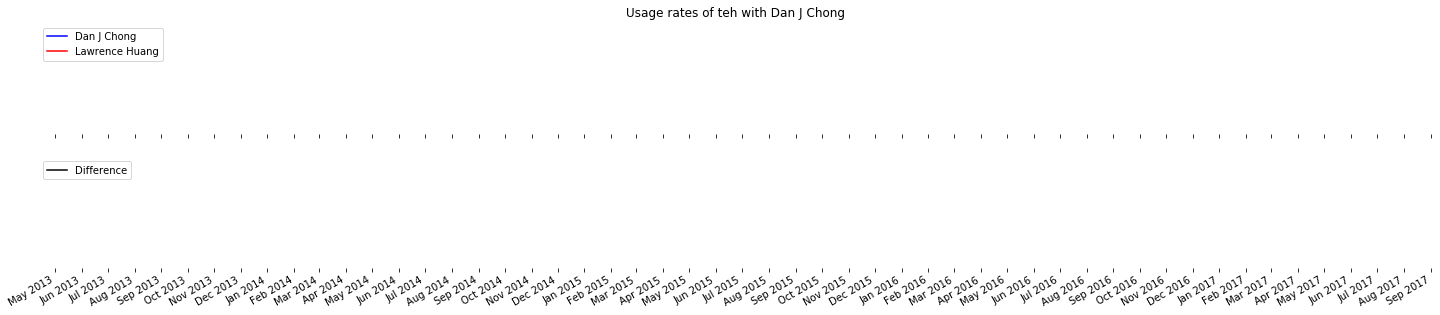

Influence score: 1.1248745338208261
A positive influence score means you influenced the other person.
    (aka your usage rate was initially higher than the other person)

    A negative influence score the other person influenced you.
    (aka your usage rate was initially lower than the other person)


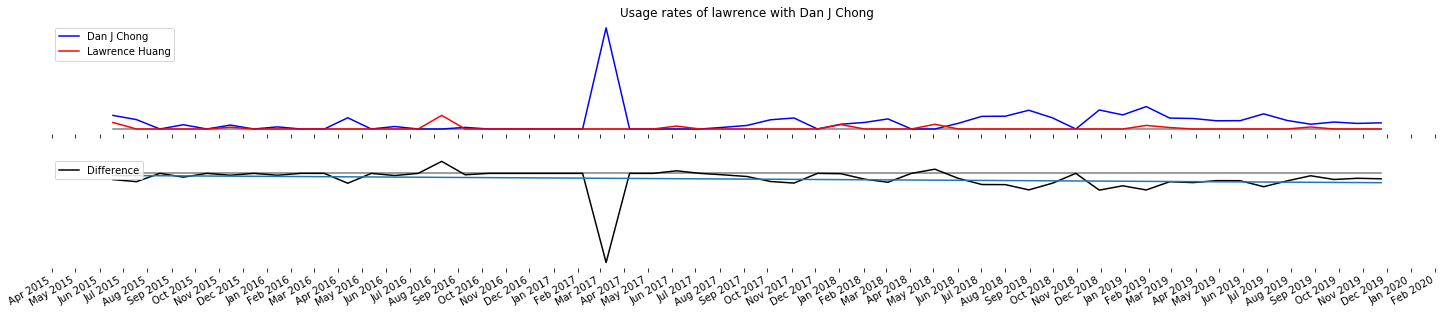

Influence score: 0.06726027704917302
A positive influence score means you influenced the other person.
    (aka your usage rate was initially higher than the other person)

    A negative influence score the other person influenced you.
    (aka your usage rate was initially lower than the other person)


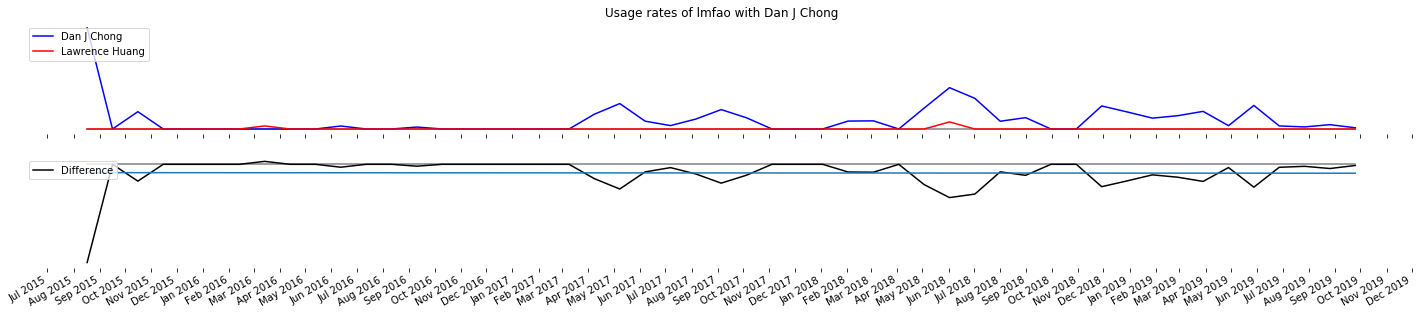

Influence score: -0.2009804632886663
A positive influence score means you influenced the other person.
    (aka your usage rate was initially higher than the other person)

    A negative influence score the other person influenced you.
    (aka your usage rate was initially lower than the other person)


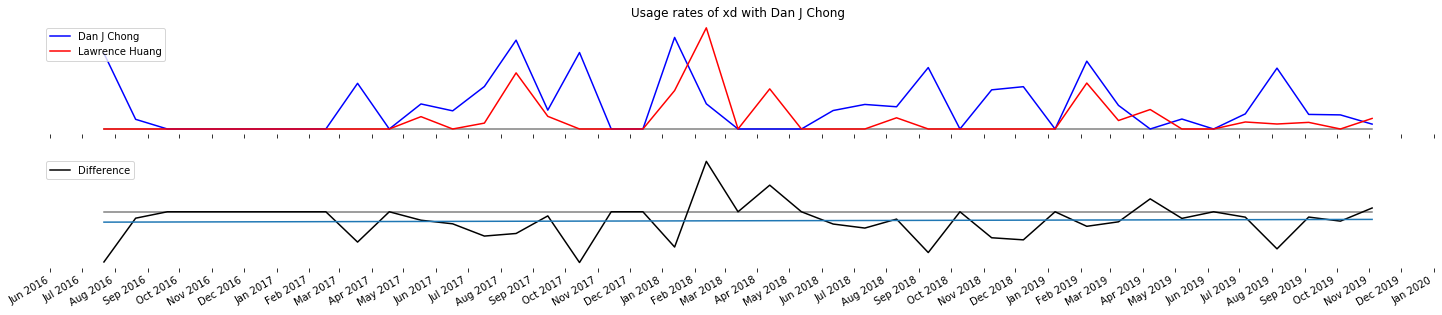

Influence score: 1.406370688410331
A positive influence score means you influenced the other person.
    (aka your usage rate was initially higher than the other person)

    A negative influence score the other person influenced you.
    (aka your usage rate was initially lower than the other person)


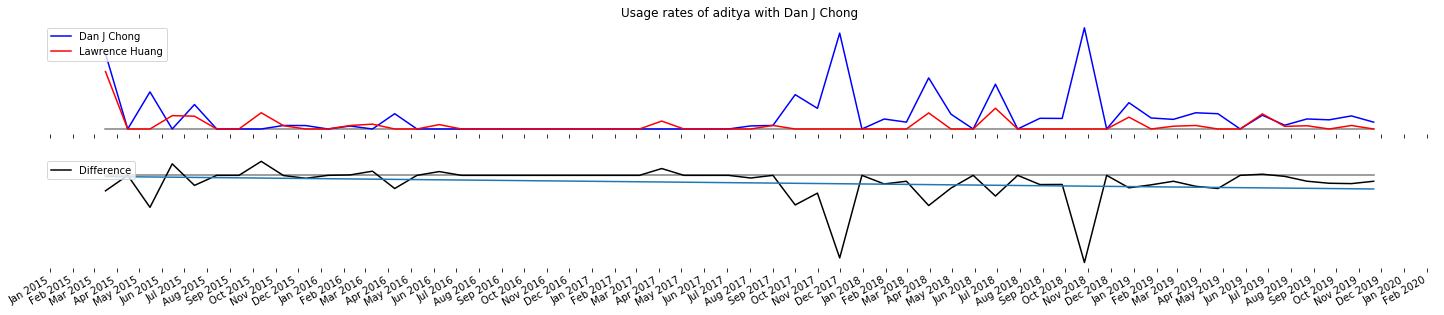

Influence score: -1.2051360725526532
A positive influence score means you influenced the other person.
    (aka your usage rate was initially higher than the other person)

    A negative influence score the other person influenced you.
    (aka your usage rate was initially lower than the other person)


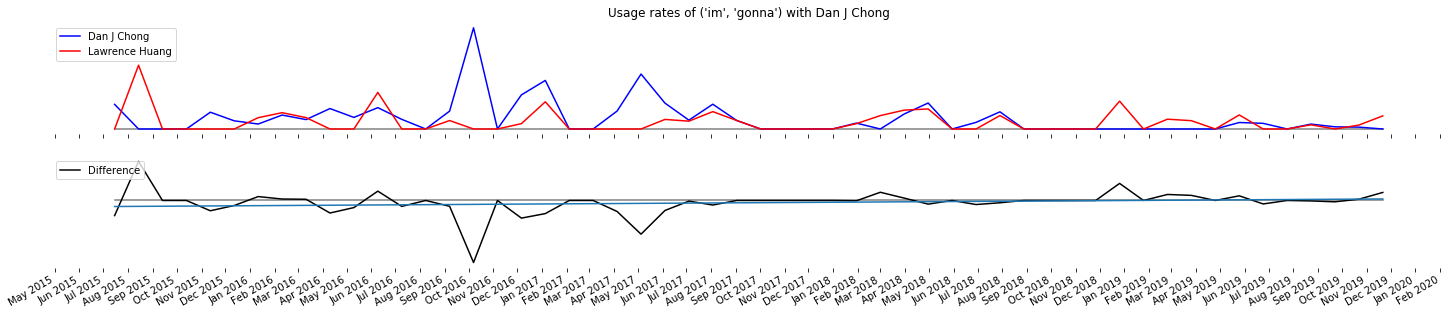

Influence score: 2.9412178387090413
A positive influence score means you influenced the other person.
    (aka your usage rate was initially higher than the other person)

    A negative influence score the other person influenced you.
    (aka your usage rate was initially lower than the other person)


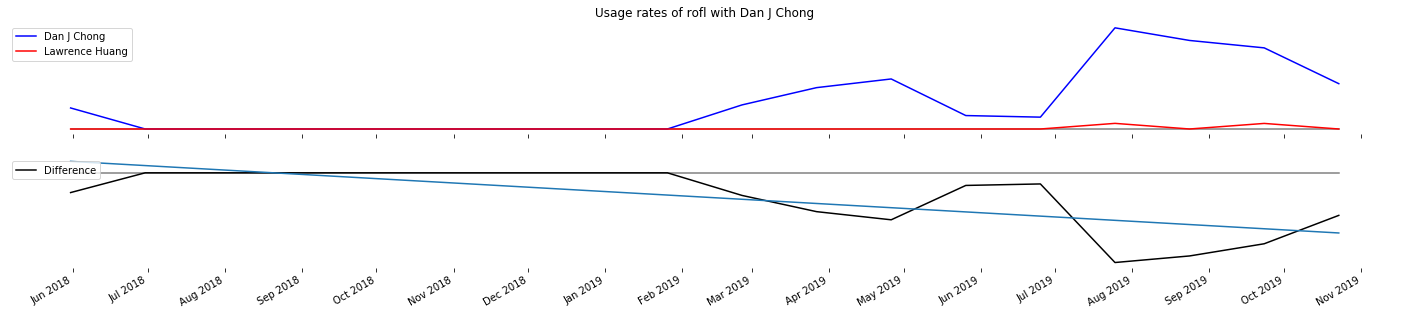

Influence score: -2.2821101977874028
A positive influence score means you influenced the other person.
    (aka your usage rate was initially higher than the other person)

    A negative influence score the other person influenced you.
    (aka your usage rate was initially lower than the other person)


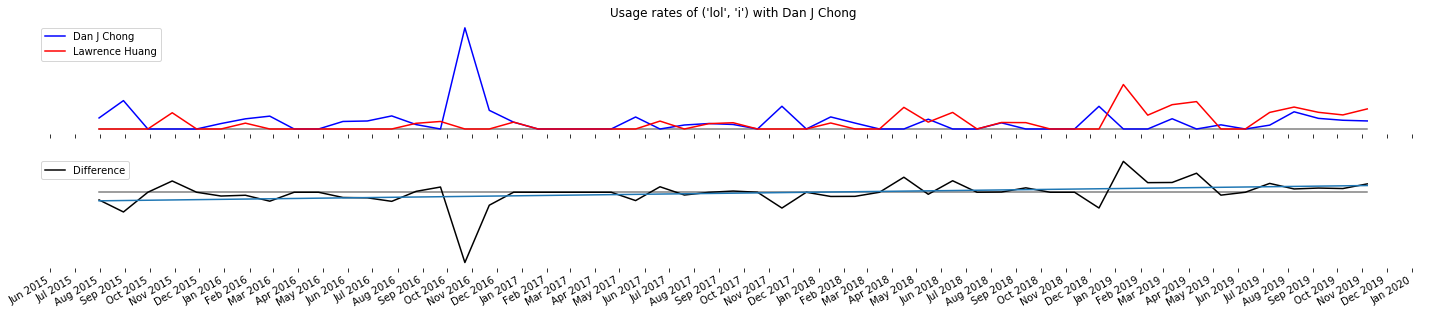

Influence score: 1.472618751892051
A positive influence score means you influenced the other person.
    (aka your usage rate was initially higher than the other person)

    A negative influence score the other person influenced you.
    (aka your usage rate was initially lower than the other person)


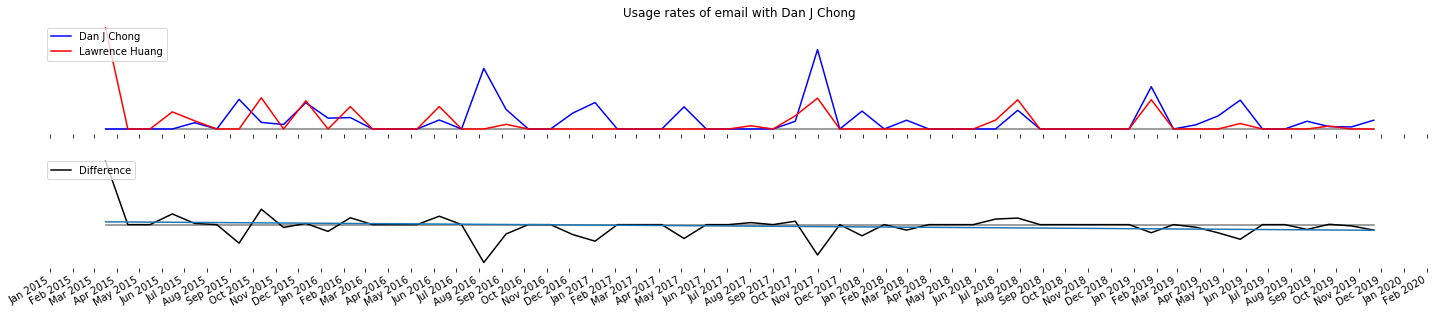

Influence score: 1.7126571947883897
A positive influence score means you influenced the other person.
    (aka your usage rate was initially higher than the other person)

    A negative influence score the other person influenced you.
    (aka your usage rate was initially lower than the other person)


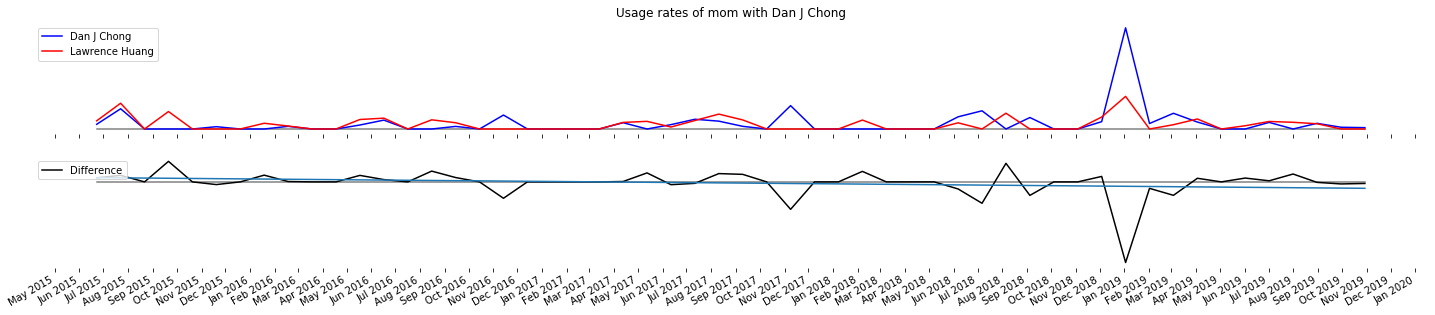

Influence score: -4.072099953390306
A positive influence score means you influenced the other person.
    (aka your usage rate was initially higher than the other person)

    A negative influence score the other person influenced you.
    (aka your usage rate was initially lower than the other person)


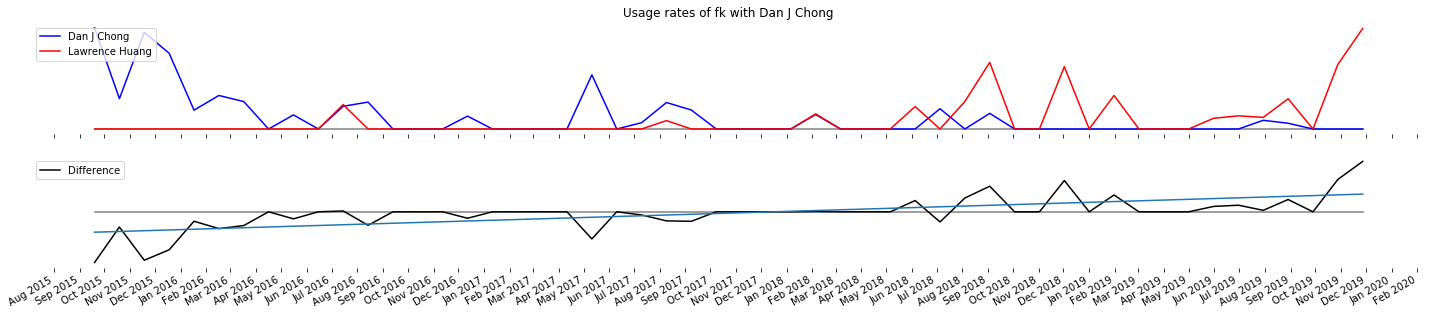

Influence score: -0.7111778398650942
A positive influence score means you influenced the other person.
    (aka your usage rate was initially higher than the other person)

    A negative influence score the other person influenced you.
    (aka your usage rate was initially lower than the other person)


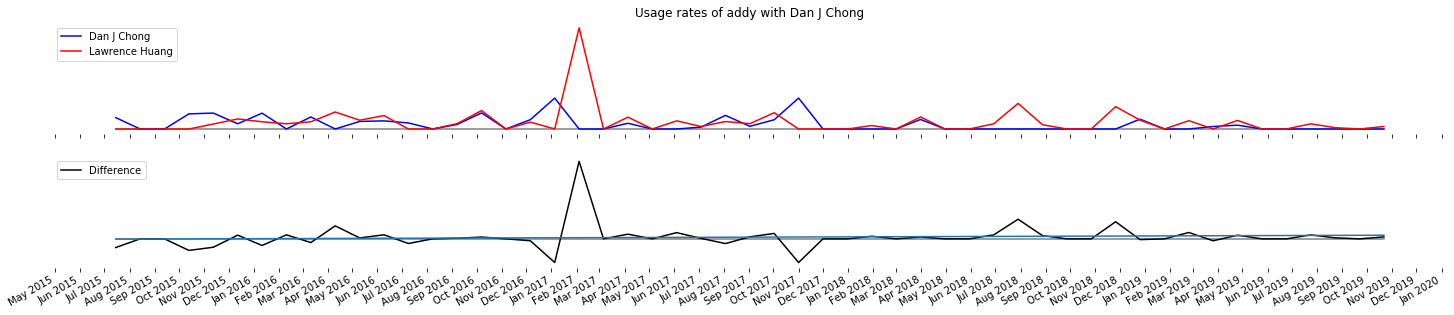

Influence score: -0.9888723290780735
A positive influence score means you influenced the other person.
    (aka your usage rate was initially higher than the other person)

    A negative influence score the other person influenced you.
    (aka your usage rate was initially lower than the other person)


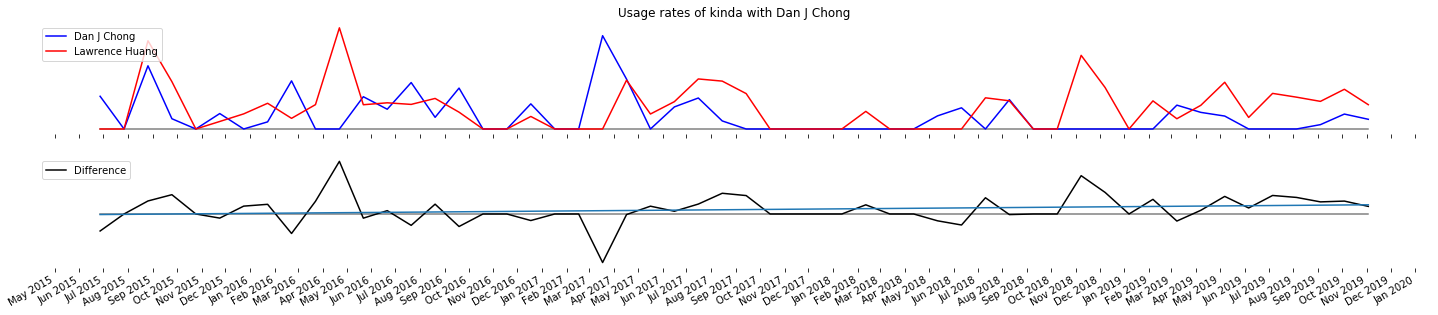

Influence score: 1.7994603087369918
A positive influence score means you influenced the other person.
    (aka your usage rate was initially higher than the other person)

    A negative influence score the other person influenced you.
    (aka your usage rate was initially lower than the other person)


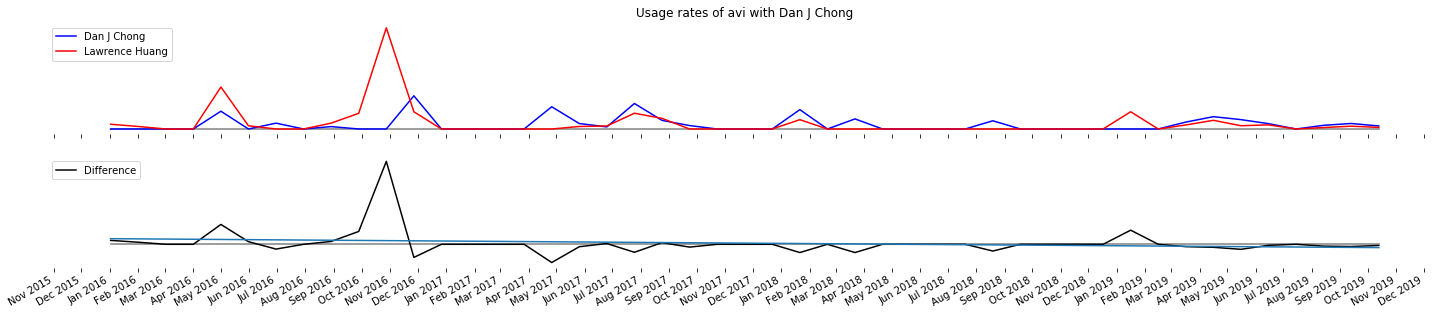

Influence score: -2.0984617074969263
A positive influence score means you influenced the other person.
    (aka your usage rate was initially higher than the other person)

    A negative influence score the other person influenced you.
    (aka your usage rate was initially lower than the other person)


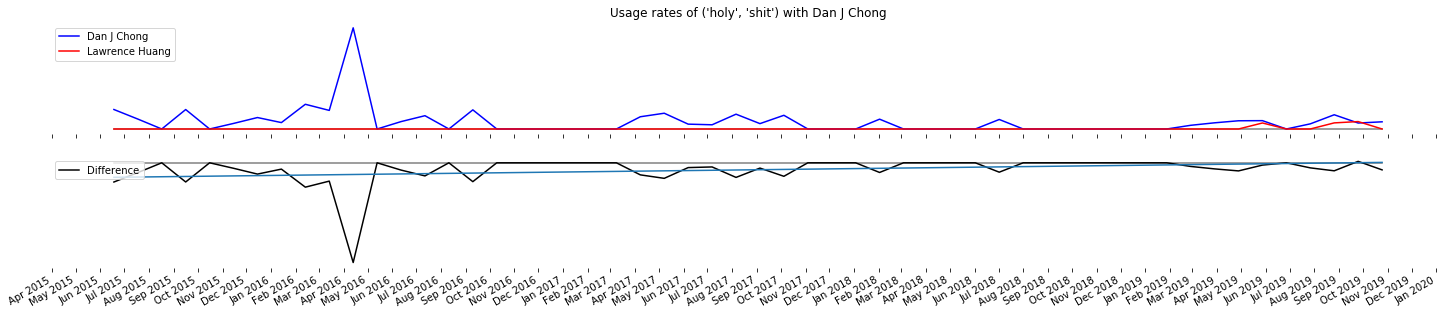

Influence score: -1.4716429922285674
A positive influence score means you influenced the other person.
    (aka your usage rate was initially higher than the other person)

    A negative influence score the other person influenced you.
    (aka your usage rate was initially lower than the other person)


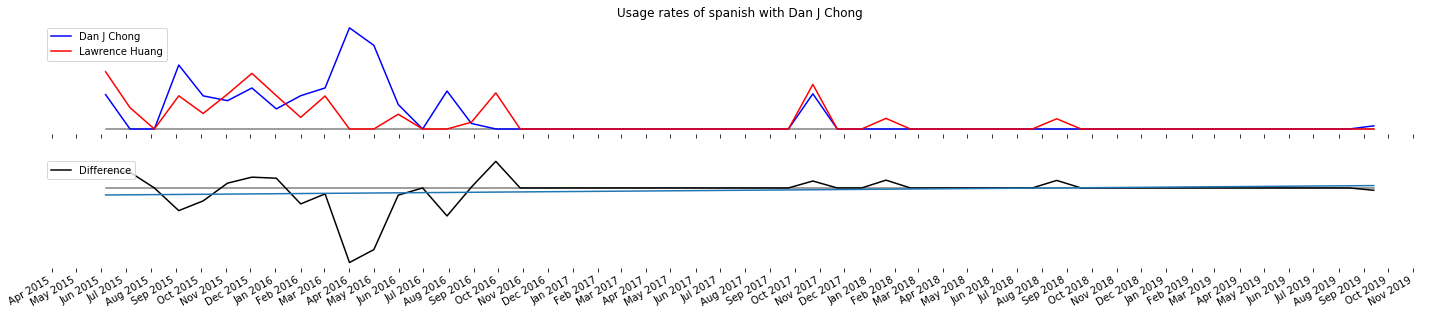

Influence score: nan
A positive influence score means you influenced the other person.
    (aka your usage rate was initially higher than the other person)

    A negative influence score the other person influenced you.
    (aka your usage rate was initially lower than the other person)


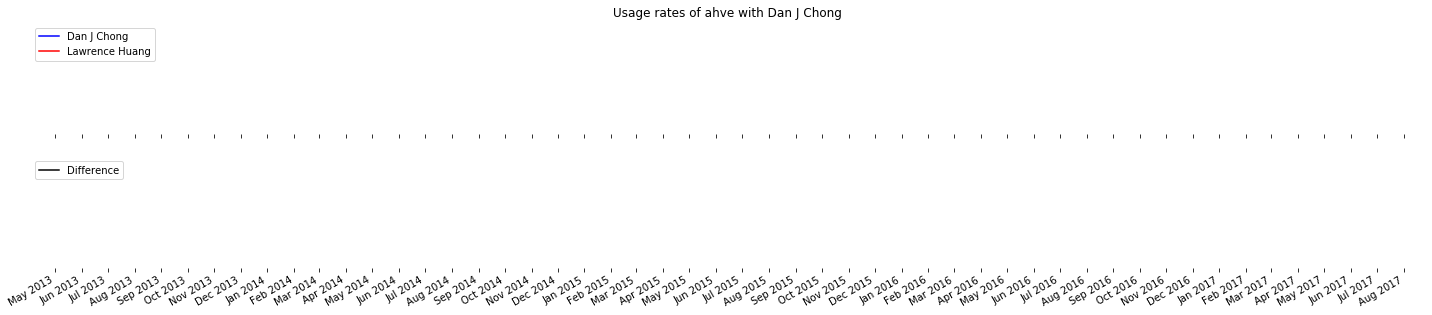

Influence score: -0.19985441417525626
A positive influence score means you influenced the other person.
    (aka your usage rate was initially higher than the other person)

    A negative influence score the other person influenced you.
    (aka your usage rate was initially lower than the other person)


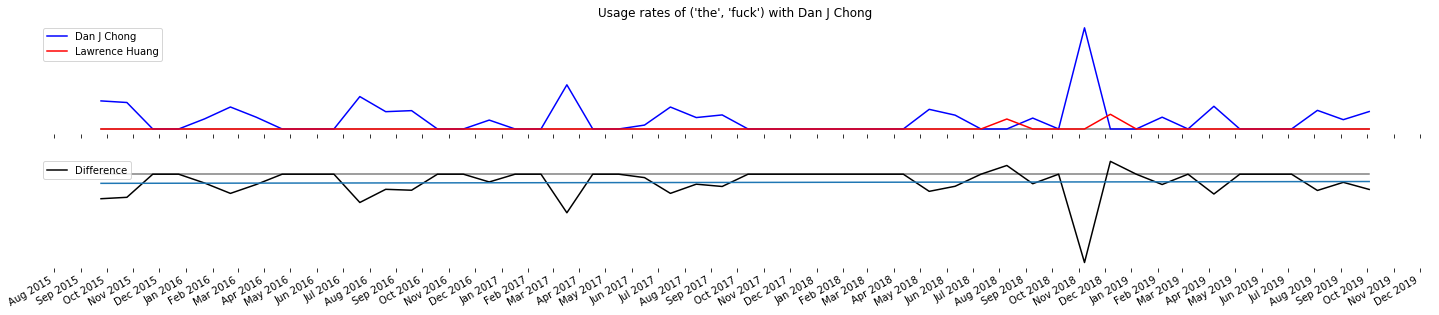

Influence score: 0.17584156991336042
A positive influence score means you influenced the other person.
    (aka your usage rate was initially higher than the other person)

    A negative influence score the other person influenced you.
    (aka your usage rate was initially lower than the other person)


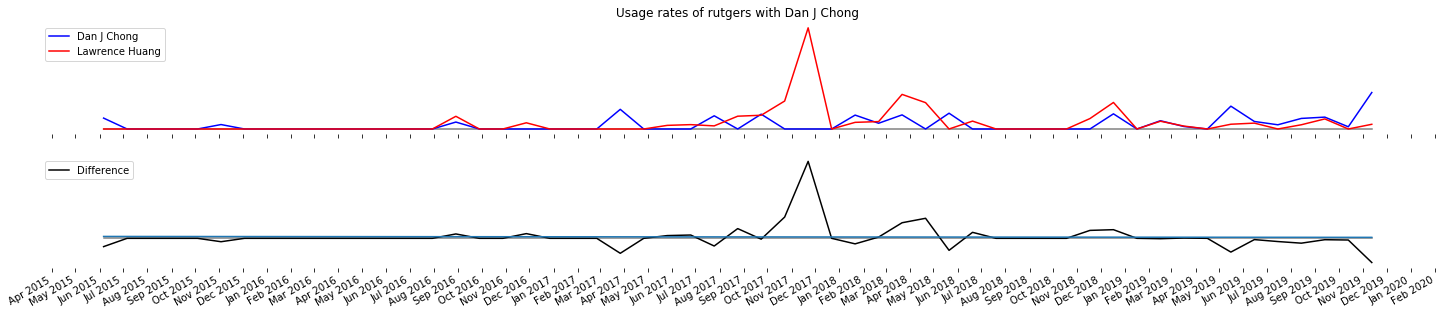

Influence score: nan
A positive influence score means you influenced the other person.
    (aka your usage rate was initially higher than the other person)

    A negative influence score the other person influenced you.
    (aka your usage rate was initially lower than the other person)


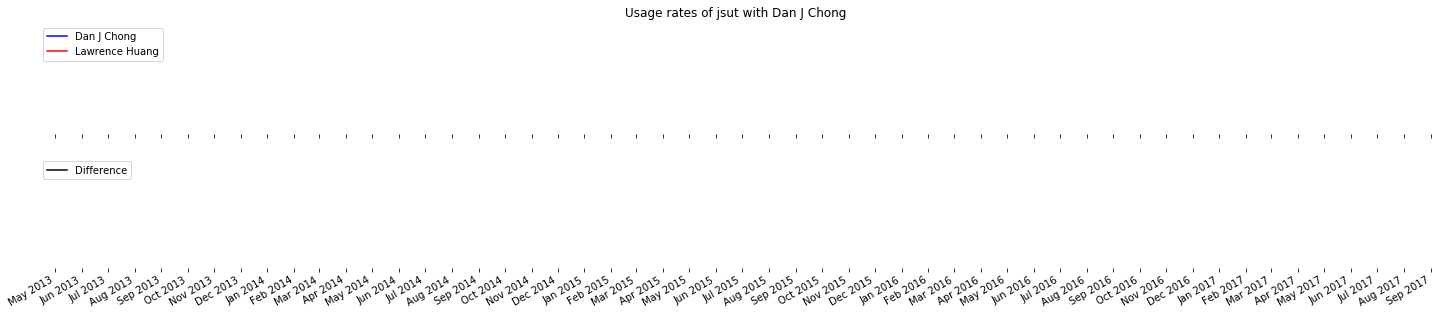

Influence score: nan
A positive influence score means you influenced the other person.
    (aka your usage rate was initially higher than the other person)

    A negative influence score the other person influenced you.
    (aka your usage rate was initially lower than the other person)


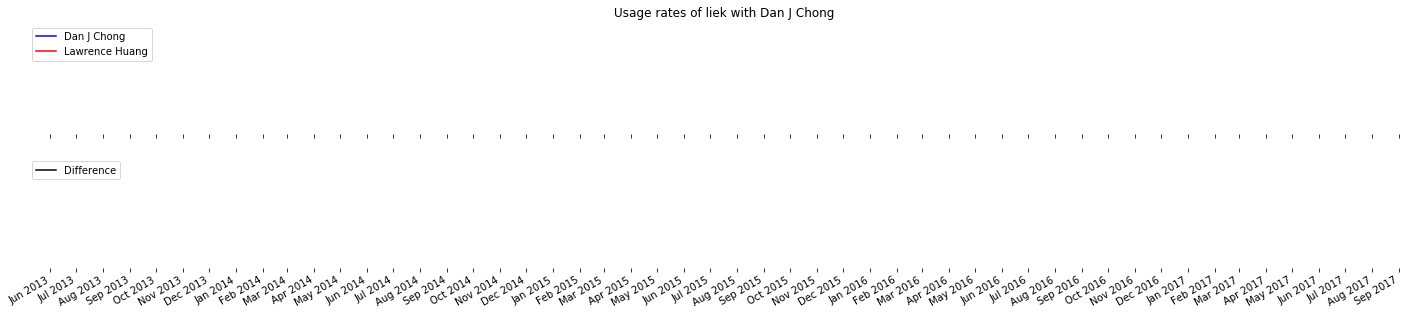

Influence score: -0.5374728237094303
A positive influence score means you influenced the other person.
    (aka your usage rate was initially higher than the other person)

    A negative influence score the other person influenced you.
    (aka your usage rate was initially lower than the other person)


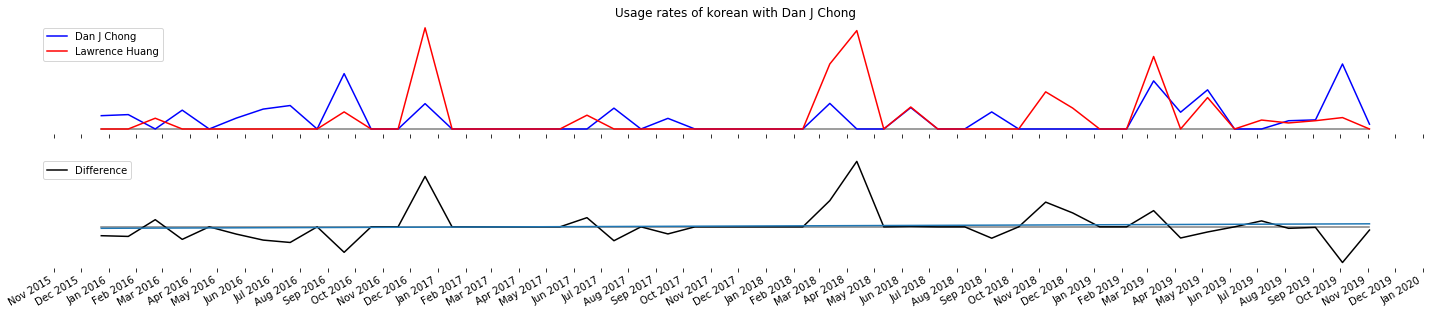

Influence score: nan
A positive influence score means you influenced the other person.
    (aka your usage rate was initially higher than the other person)

    A negative influence score the other person influenced you.
    (aka your usage rate was initially lower than the other person)


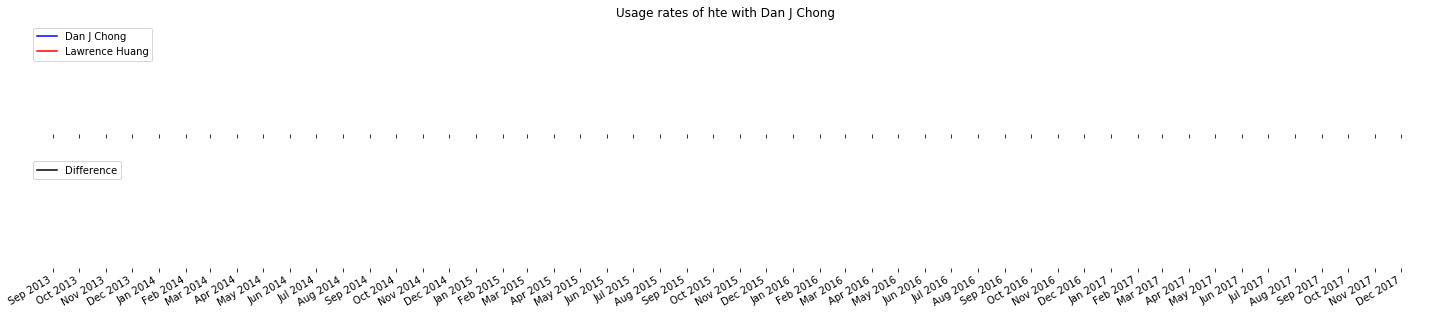

Influence score: -1.7282645830156844
A positive influence score means you influenced the other person.
    (aka your usage rate was initially higher than the other person)

    A negative influence score the other person influenced you.
    (aka your usage rate was initially lower than the other person)


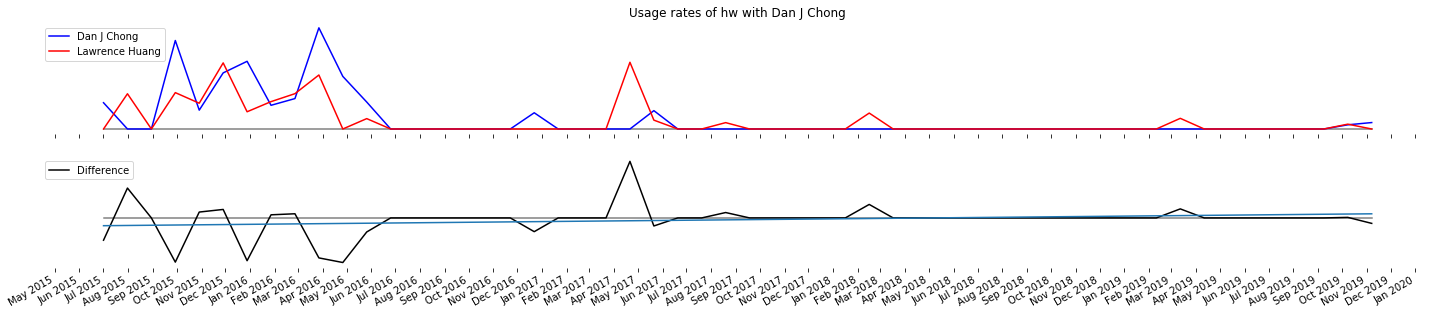

Influence score: -1.155844797942047
A positive influence score means you influenced the other person.
    (aka your usage rate was initially higher than the other person)

    A negative influence score the other person influenced you.
    (aka your usage rate was initially lower than the other person)


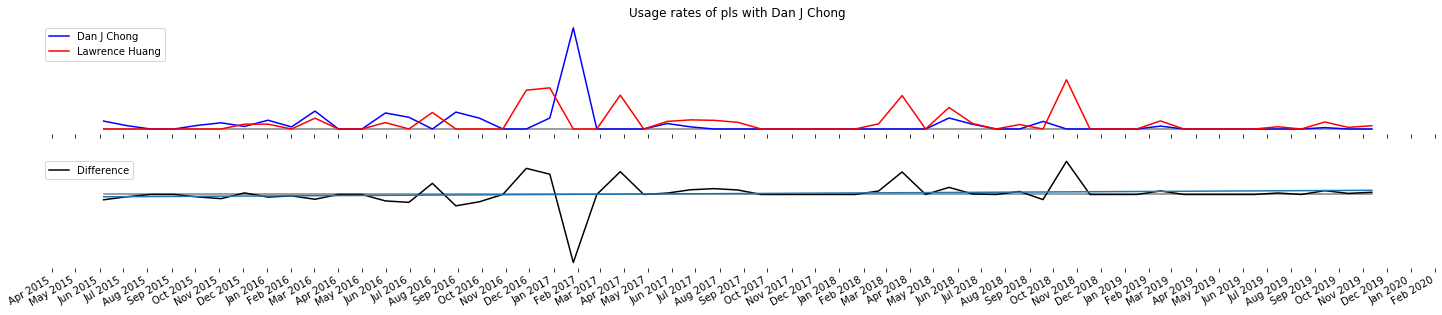

Influence score: 1.6861606320899911
A positive influence score means you influenced the other person.
    (aka your usage rate was initially higher than the other person)

    A negative influence score the other person influenced you.
    (aka your usage rate was initially lower than the other person)


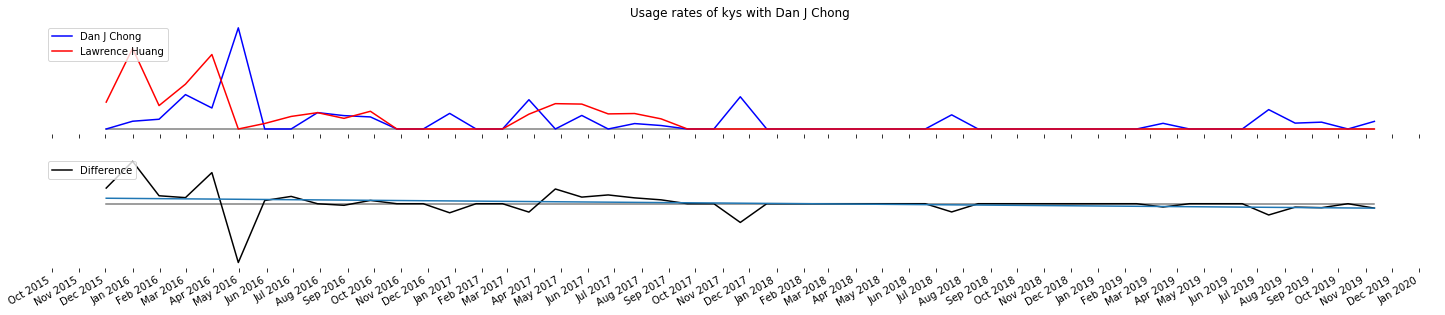

Influence score: -0.771166741509109
A positive influence score means you influenced the other person.
    (aka your usage rate was initially higher than the other person)

    A negative influence score the other person influenced you.
    (aka your usage rate was initially lower than the other person)


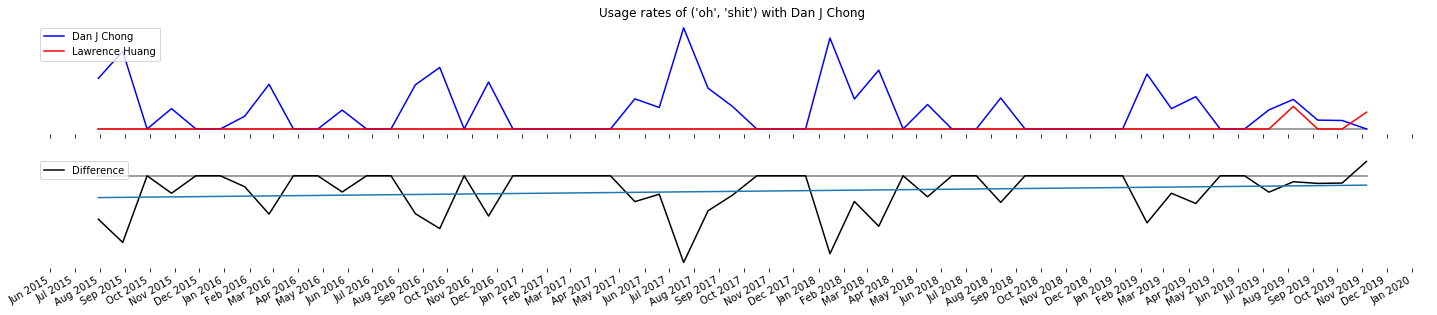

Influence score: 0.5545260889373975
A positive influence score means you influenced the other person.
    (aka your usage rate was initially higher than the other person)

    A negative influence score the other person influenced you.
    (aka your usage rate was initially lower than the other person)


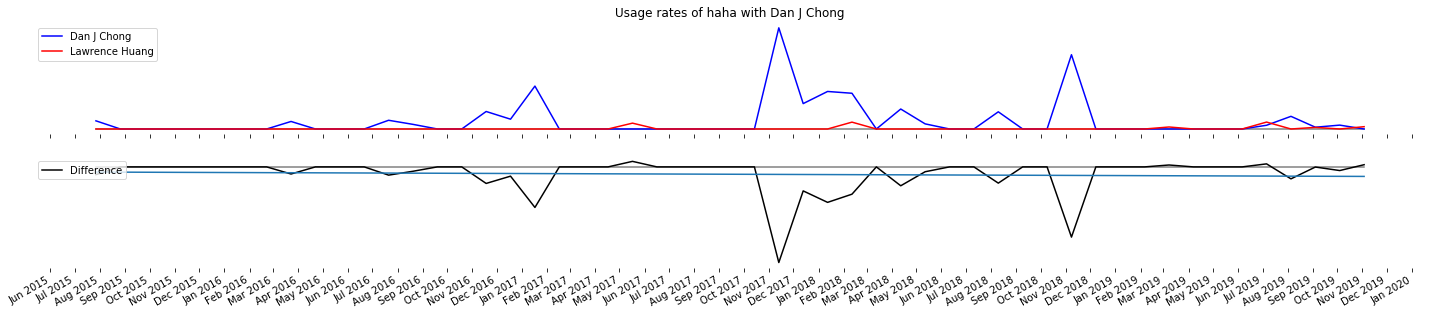

Influence score: nan
A positive influence score means you influenced the other person.
    (aka your usage rate was initially higher than the other person)

    A negative influence score the other person influenced you.
    (aka your usage rate was initially lower than the other person)


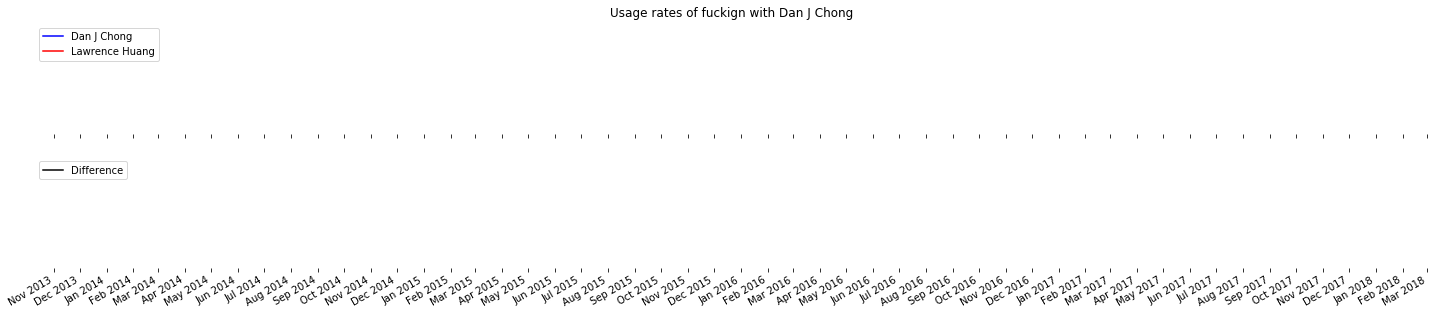

Influence score: -0.8391338333147301
A positive influence score means you influenced the other person.
    (aka your usage rate was initially higher than the other person)

    A negative influence score the other person influenced you.
    (aka your usage rate was initially lower than the other person)


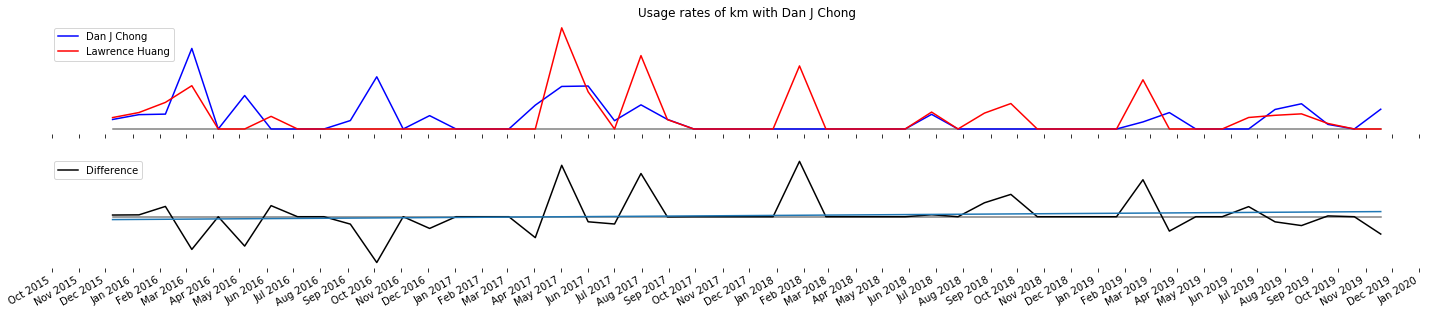

Influence score: 1.45778536494065
A positive influence score means you influenced the other person.
    (aka your usage rate was initially higher than the other person)

    A negative influence score the other person influenced you.
    (aka your usage rate was initially lower than the other person)


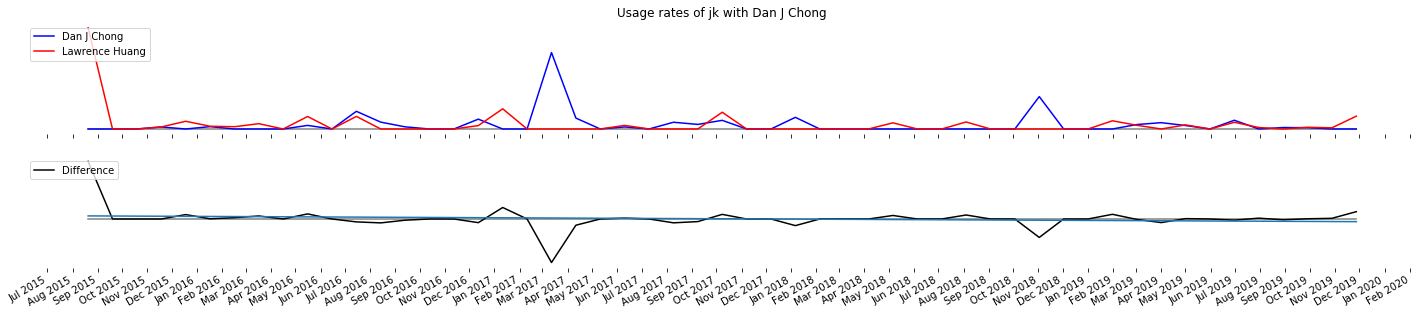

Influence score: -0.3115636917663013
A positive influence score means you influenced the other person.
    (aka your usage rate was initially higher than the other person)

    A negative influence score the other person influenced you.
    (aka your usage rate was initially lower than the other person)


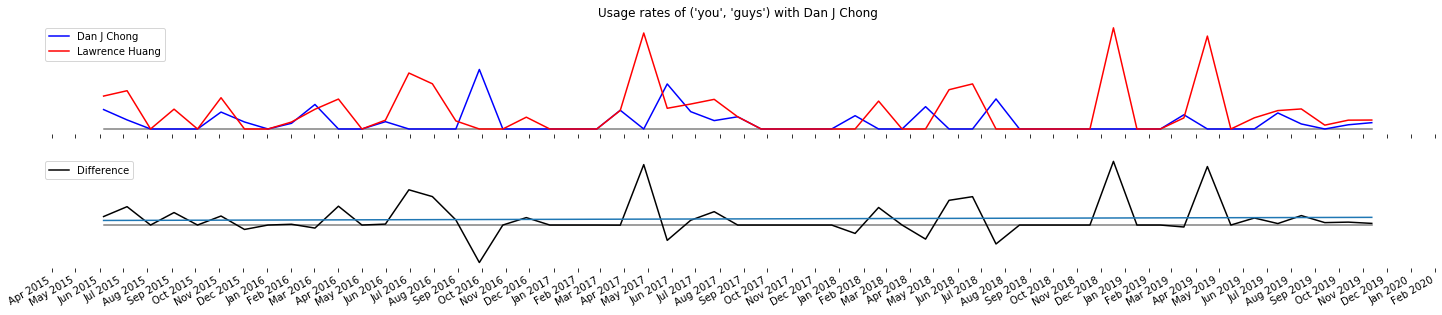

Influence score: -2.333107131094417
A positive influence score means you influenced the other person.
    (aka your usage rate was initially higher than the other person)

    A negative influence score the other person influenced you.
    (aka your usage rate was initially lower than the other person)


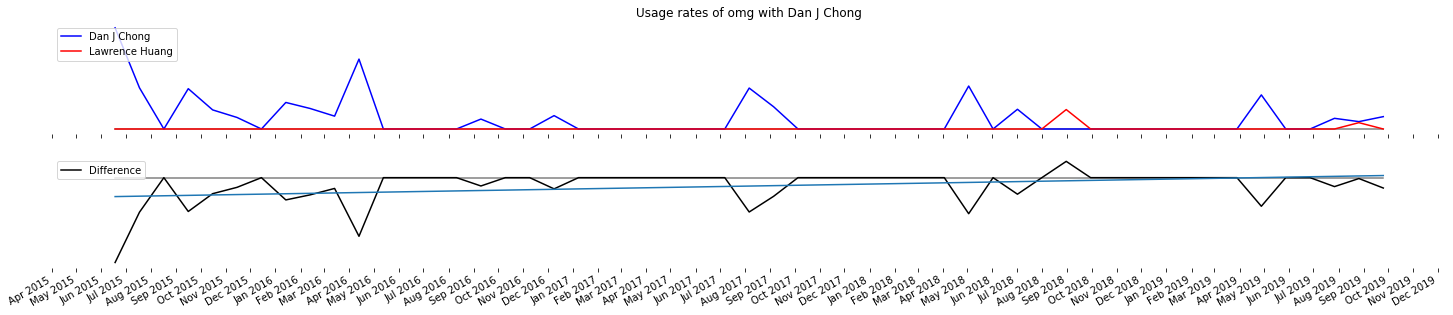

Influence score: -0.6570740780551703
A positive influence score means you influenced the other person.
    (aka your usage rate was initially higher than the other person)

    A negative influence score the other person influenced you.
    (aka your usage rate was initially lower than the other person)


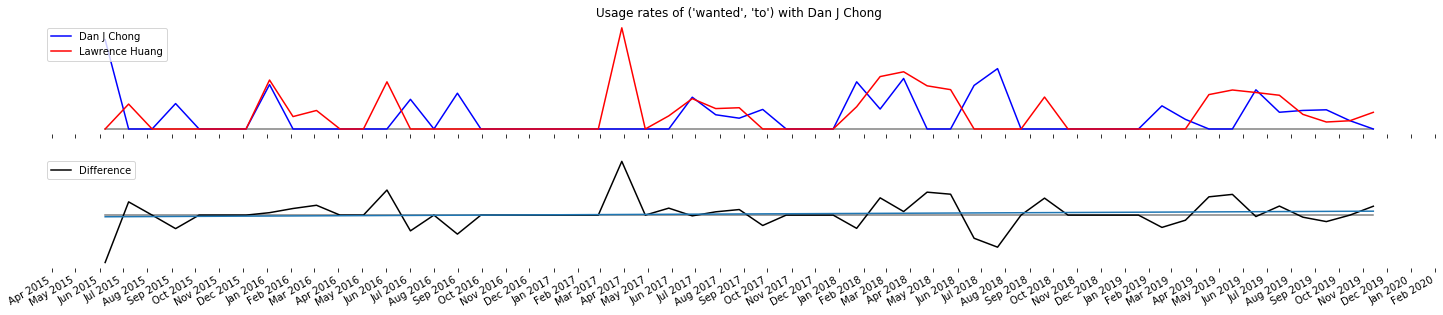

Influence score: 2.3580733986668037
A positive influence score means you influenced the other person.
    (aka your usage rate was initially higher than the other person)

    A negative influence score the other person influenced you.
    (aka your usage rate was initially lower than the other person)


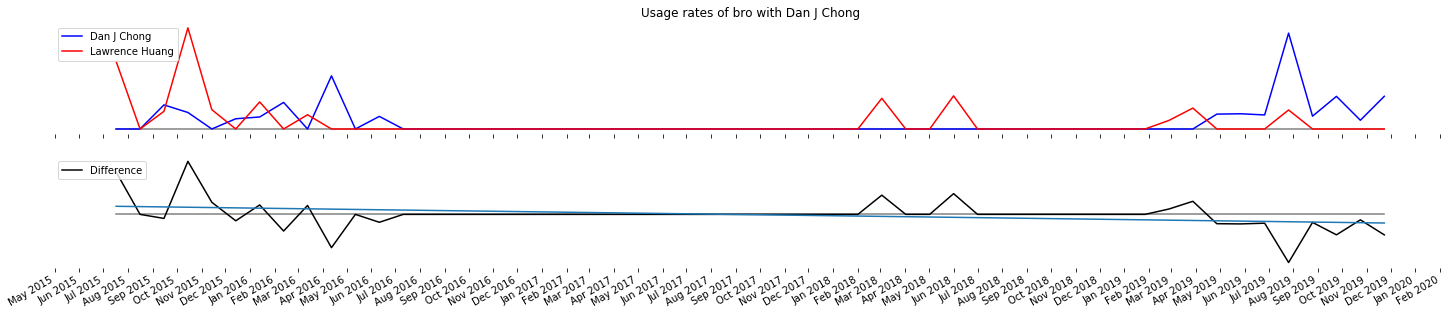

Influence score: nan
A positive influence score means you influenced the other person.
    (aka your usage rate was initially higher than the other person)

    A negative influence score the other person influenced you.
    (aka your usage rate was initially lower than the other person)


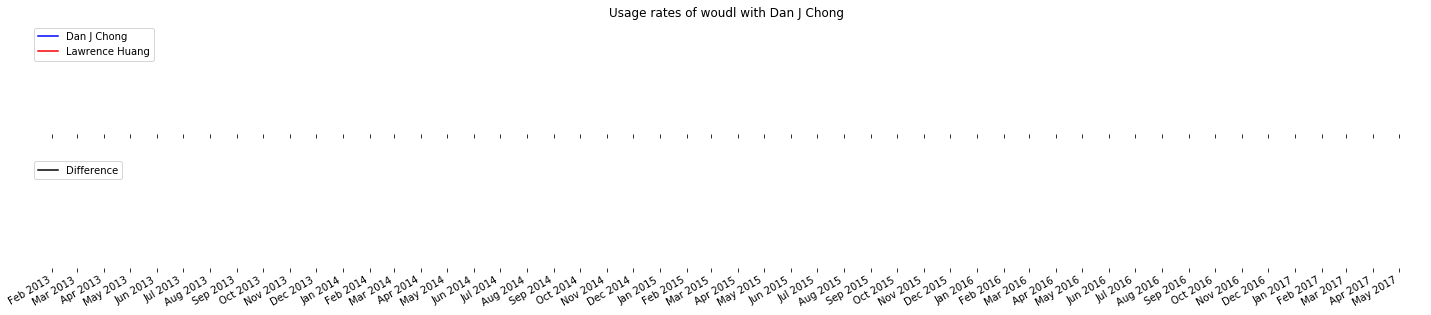

Influence score: -2.550544384373959
A positive influence score means you influenced the other person.
    (aka your usage rate was initially higher than the other person)

    A negative influence score the other person influenced you.
    (aka your usage rate was initially lower than the other person)


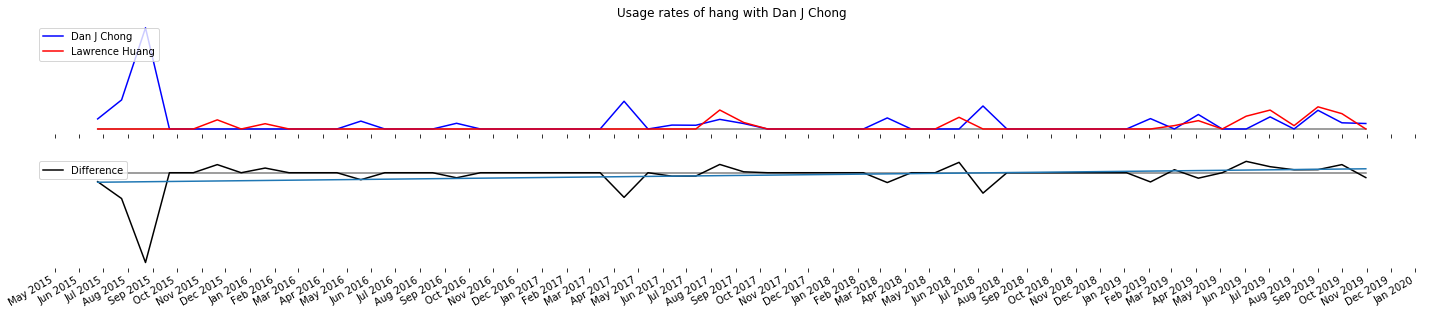

Influence score: -1.359510826956586
A positive influence score means you influenced the other person.
    (aka your usage rate was initially higher than the other person)

    A negative influence score the other person influenced you.
    (aka your usage rate was initially lower than the other person)


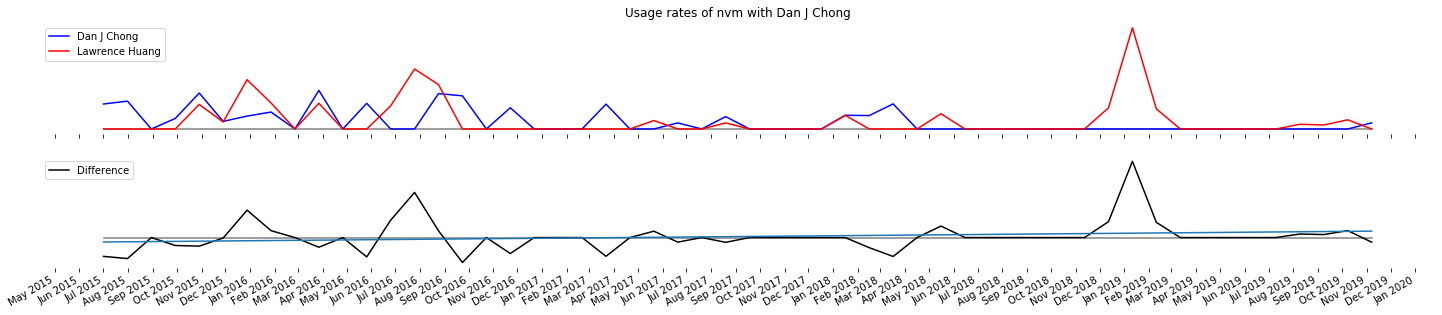

Influence score: 0.9116880602192231
A positive influence score means you influenced the other person.
    (aka your usage rate was initially higher than the other person)

    A negative influence score the other person influenced you.
    (aka your usage rate was initially lower than the other person)


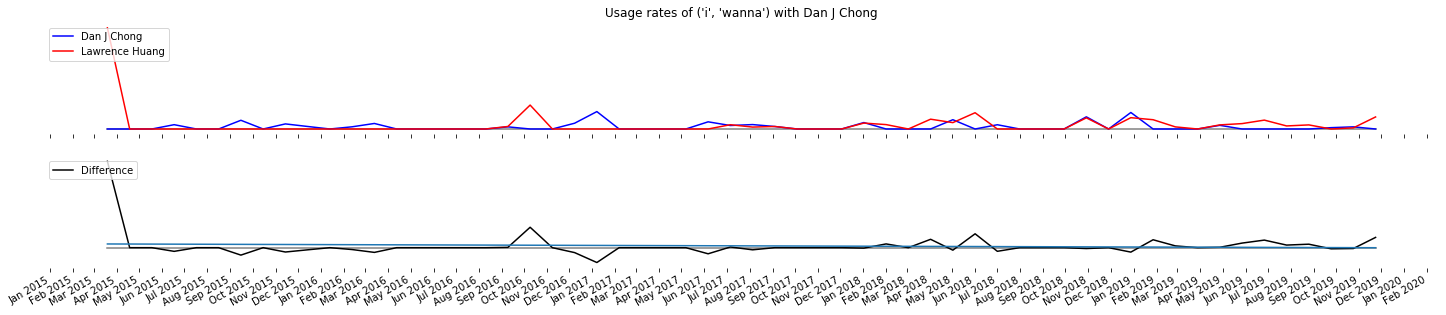

Influence score: 2.487721057566322
A positive influence score means you influenced the other person.
    (aka your usage rate was initially higher than the other person)

    A negative influence score the other person influenced you.
    (aka your usage rate was initially lower than the other person)


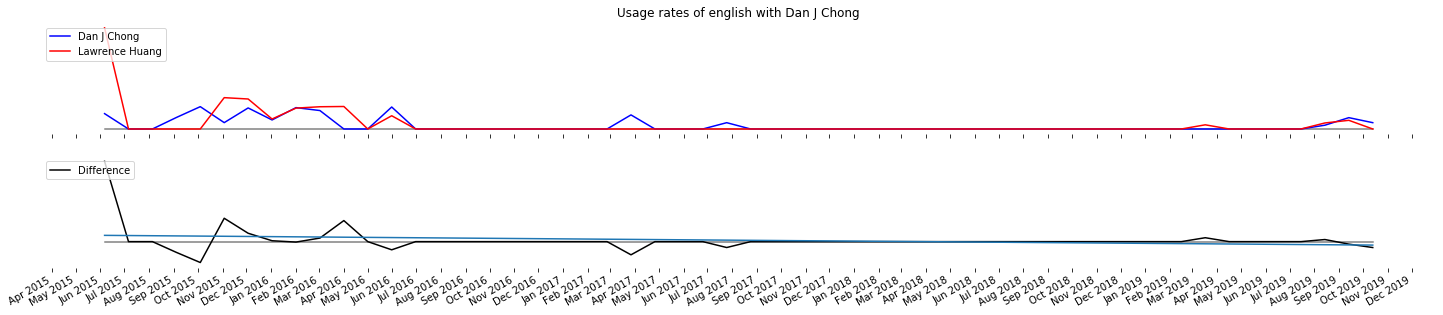

Influence score: -0.6380269664864374
A positive influence score means you influenced the other person.
    (aka your usage rate was initially higher than the other person)

    A negative influence score the other person influenced you.
    (aka your usage rate was initially lower than the other person)


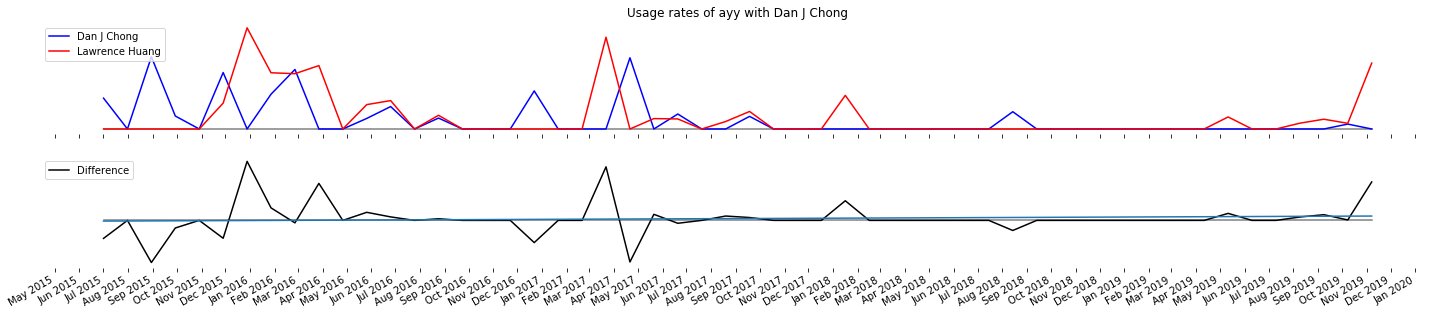

Influence score: 1.766679622905753
A positive influence score means you influenced the other person.
    (aka your usage rate was initially higher than the other person)

    A negative influence score the other person influenced you.
    (aka your usage rate was initially lower than the other person)


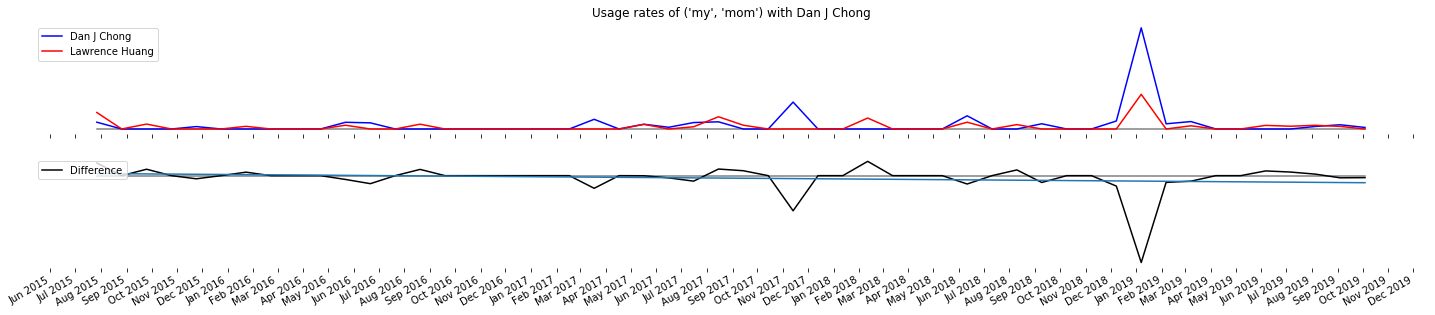

Influence score: 0.7086447042141119
A positive influence score means you influenced the other person.
    (aka your usage rate was initially higher than the other person)

    A negative influence score the other person influenced you.
    (aka your usage rate was initially lower than the other person)


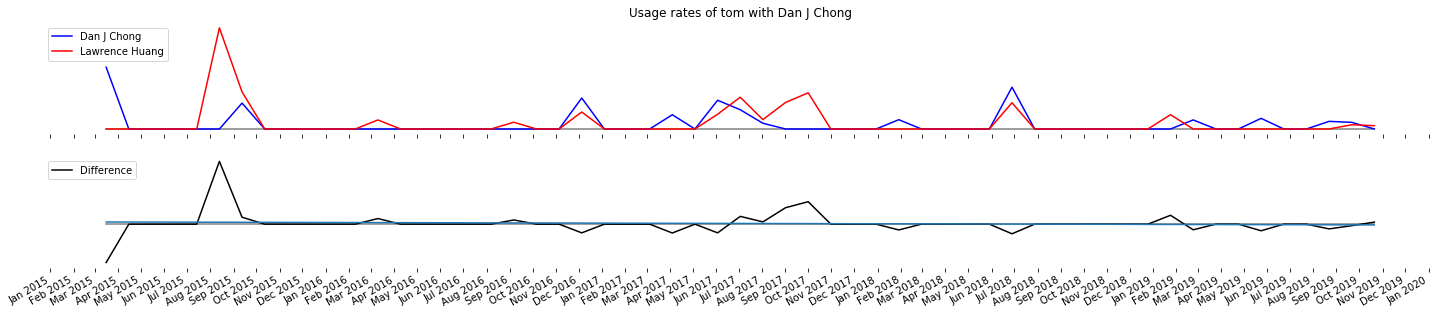

Influence score: -1.5190410007970638
A positive influence score means you influenced the other person.
    (aka your usage rate was initially higher than the other person)

    A negative influence score the other person influenced you.
    (aka your usage rate was initially lower than the other person)


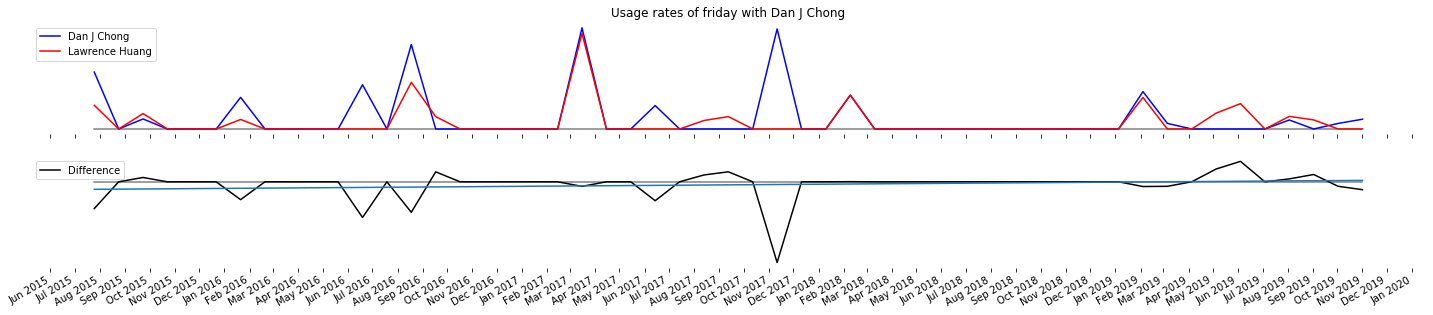

Influence score: -1.3613053903578716
A positive influence score means you influenced the other person.
    (aka your usage rate was initially higher than the other person)

    A negative influence score the other person influenced you.
    (aka your usage rate was initially lower than the other person)


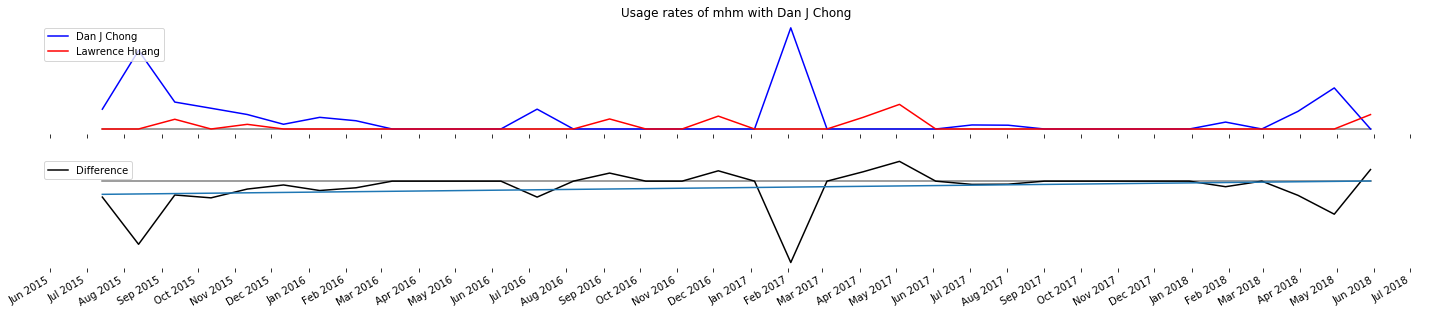

Influence score: -4.002237647780699
A positive influence score means you influenced the other person.
    (aka your usage rate was initially higher than the other person)

    A negative influence score the other person influenced you.
    (aka your usage rate was initially lower than the other person)


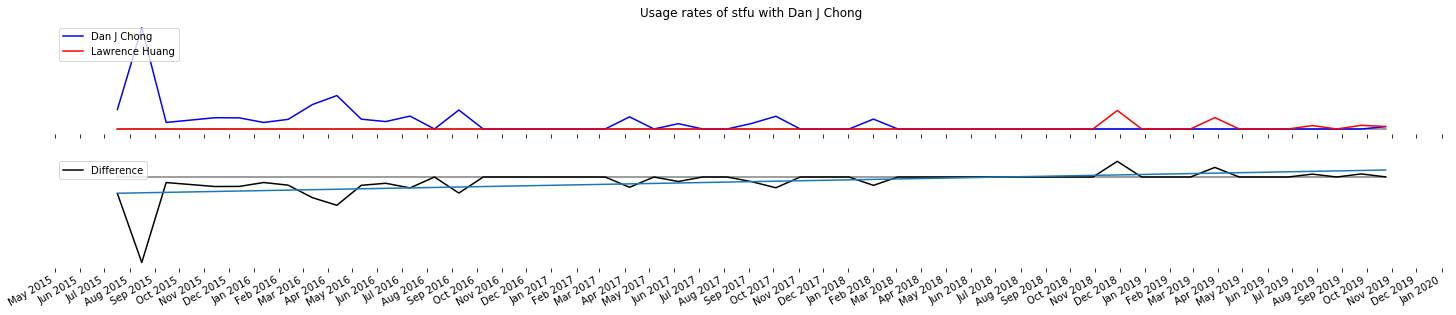

Influence score: -0.1383148139815031
A positive influence score means you influenced the other person.
    (aka your usage rate was initially higher than the other person)

    A negative influence score the other person influenced you.
    (aka your usage rate was initially lower than the other person)


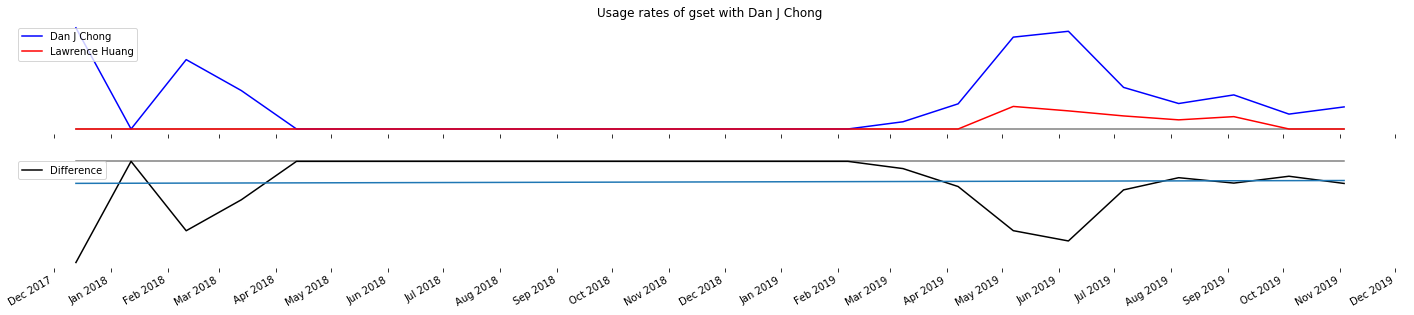

Influence score: nan
A positive influence score means you influenced the other person.
    (aka your usage rate was initially higher than the other person)

    A negative influence score the other person influenced you.
    (aka your usage rate was initially lower than the other person)


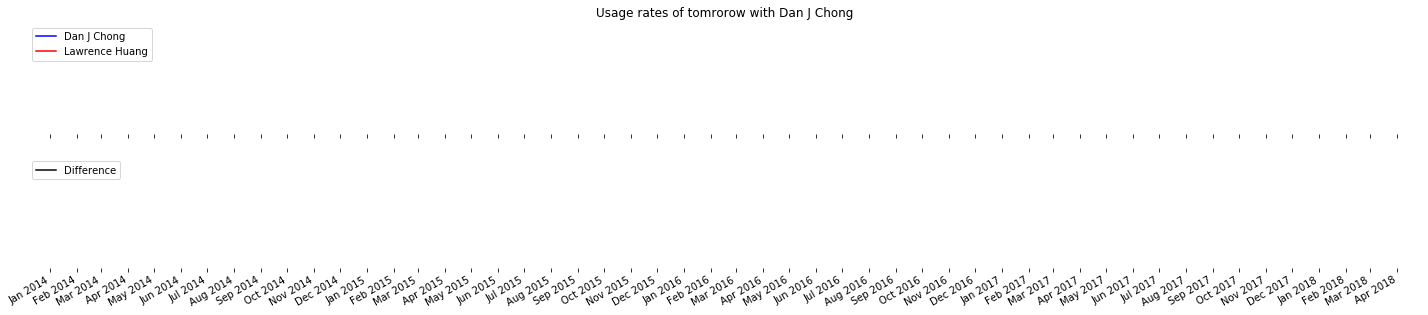

Influence score: -2.2133610570948856
A positive influence score means you influenced the other person.
    (aka your usage rate was initially higher than the other person)

    A negative influence score the other person influenced you.
    (aka your usage rate was initially lower than the other person)


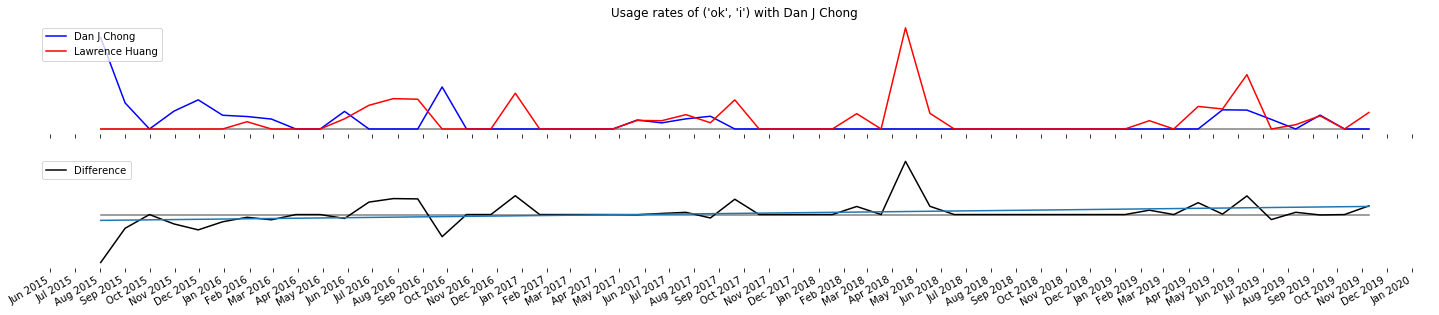

Influence score: 0.7278621751766835
A positive influence score means you influenced the other person.
    (aka your usage rate was initially higher than the other person)

    A negative influence score the other person influenced you.
    (aka your usage rate was initially lower than the other person)


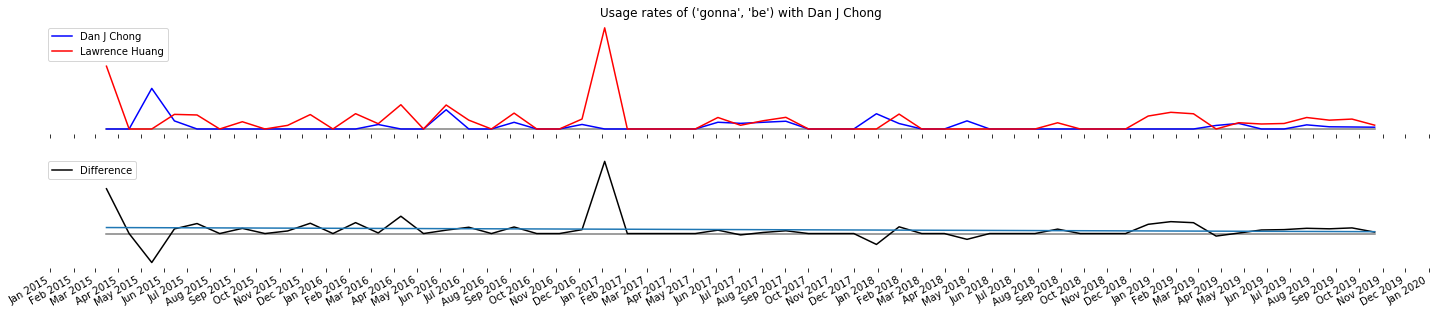

Influence score: 1.1000478111554253
A positive influence score means you influenced the other person.
    (aka your usage rate was initially higher than the other person)

    A negative influence score the other person influenced you.
    (aka your usage rate was initially lower than the other person)


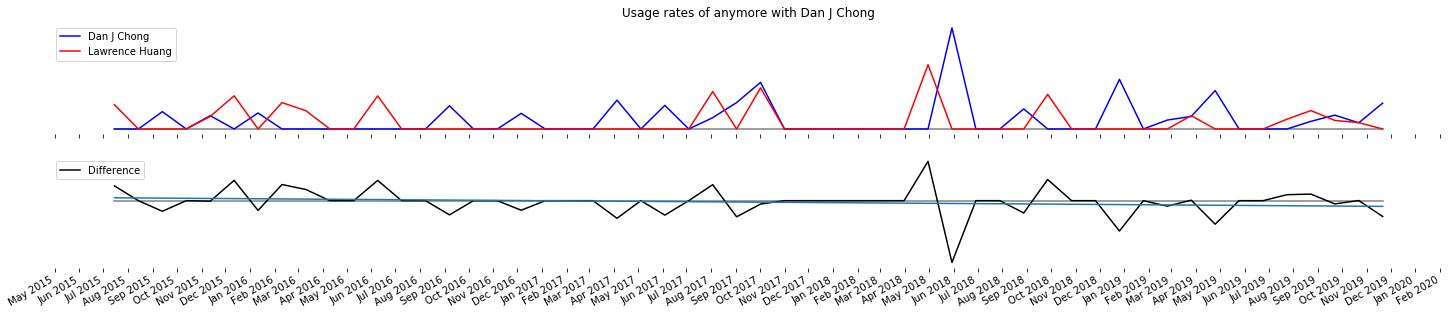

Influence score: -0.11285533083376004
A positive influence score means you influenced the other person.
    (aka your usage rate was initially higher than the other person)

    A negative influence score the other person influenced you.
    (aka your usage rate was initially lower than the other person)


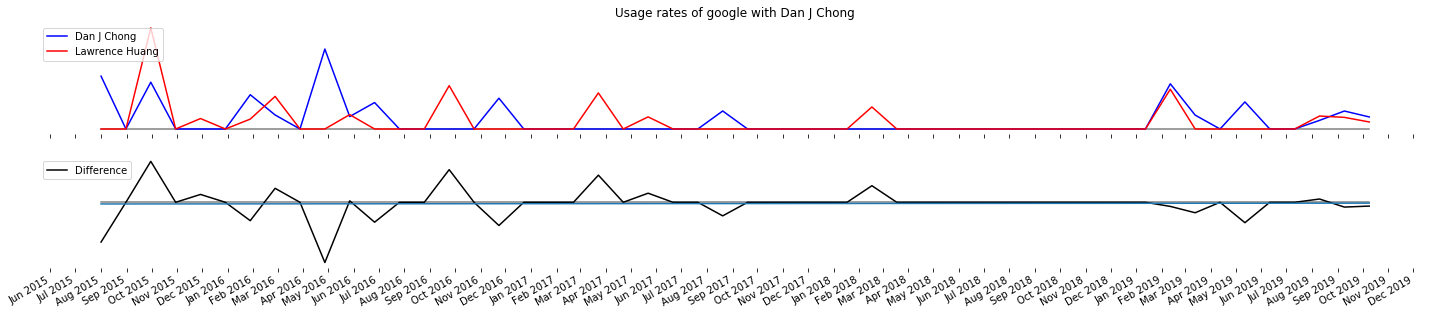

Influence score: 0.5209902716184872
A positive influence score means you influenced the other person.
    (aka your usage rate was initially higher than the other person)

    A negative influence score the other person influenced you.
    (aka your usage rate was initially lower than the other person)


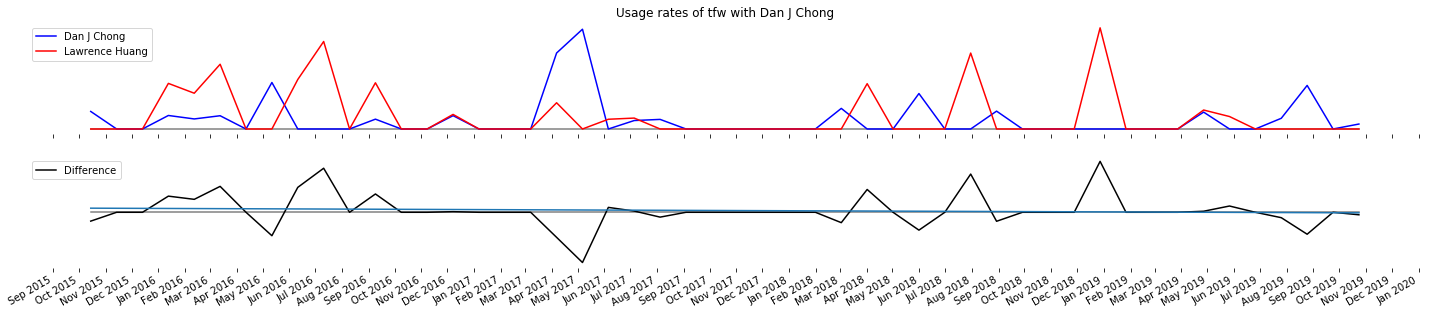

Influence score: 1.3717837404800024
A positive influence score means you influenced the other person.
    (aka your usage rate was initially higher than the other person)

    A negative influence score the other person influenced you.
    (aka your usage rate was initially lower than the other person)


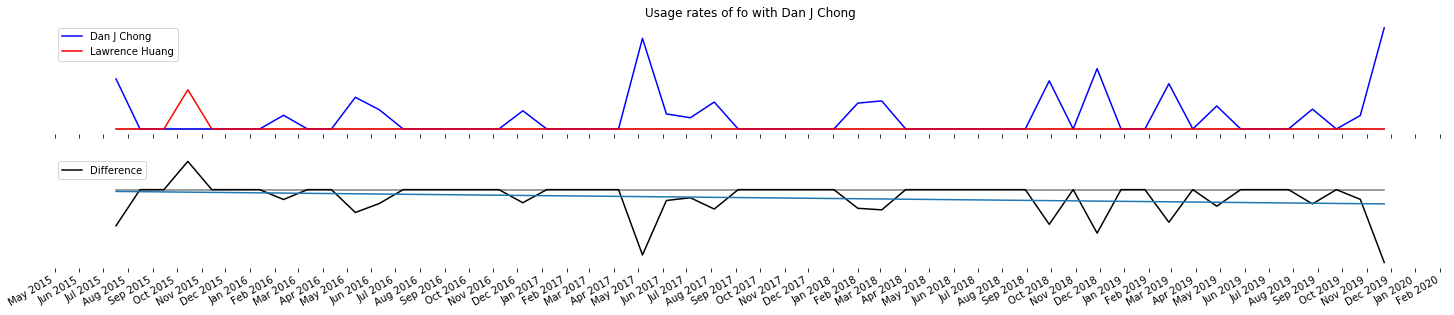

Influence score: -0.3502265156023211
A positive influence score means you influenced the other person.
    (aka your usage rate was initially higher than the other person)

    A negative influence score the other person influenced you.
    (aka your usage rate was initially lower than the other person)


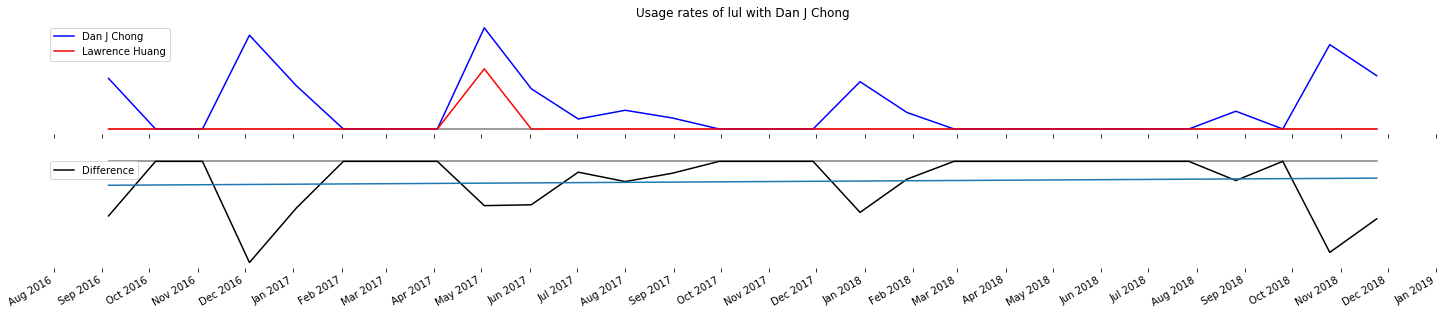

Influence score: -0.28067201073235637
A positive influence score means you influenced the other person.
    (aka your usage rate was initially higher than the other person)

    A negative influence score the other person influenced you.
    (aka your usage rate was initially lower than the other person)


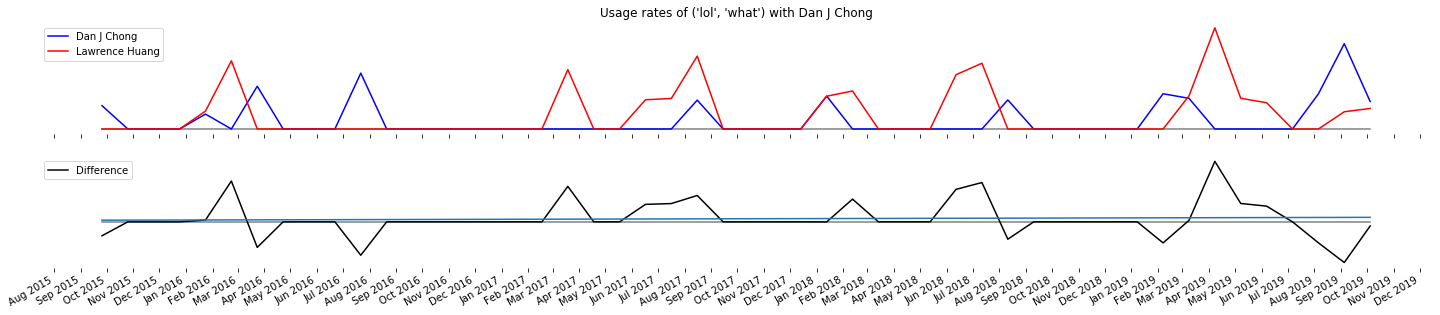

Influence score: 1.5853937890821925
A positive influence score means you influenced the other person.
    (aka your usage rate was initially higher than the other person)

    A negative influence score the other person influenced you.
    (aka your usage rate was initially lower than the other person)


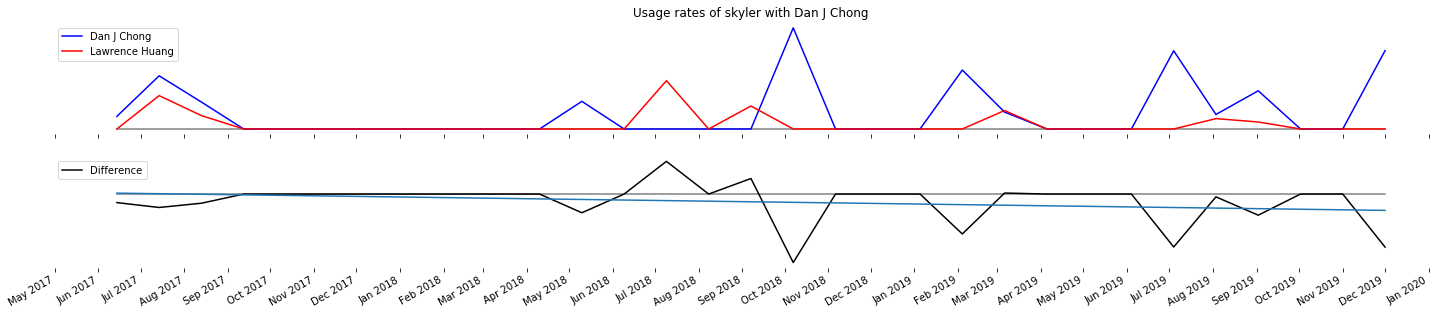

Influence score: -3.4388861710593606
A positive influence score means you influenced the other person.
    (aka your usage rate was initially higher than the other person)

    A negative influence score the other person influenced you.
    (aka your usage rate was initially lower than the other person)


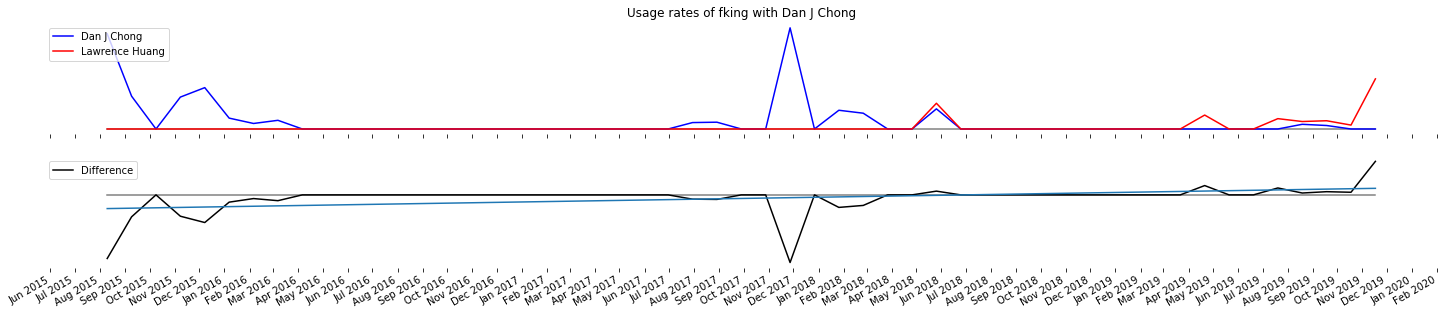

Influence score: -2.2504286833227405
A positive influence score means you influenced the other person.
    (aka your usage rate was initially higher than the other person)

    A negative influence score the other person influenced you.
    (aka your usage rate was initially lower than the other person)


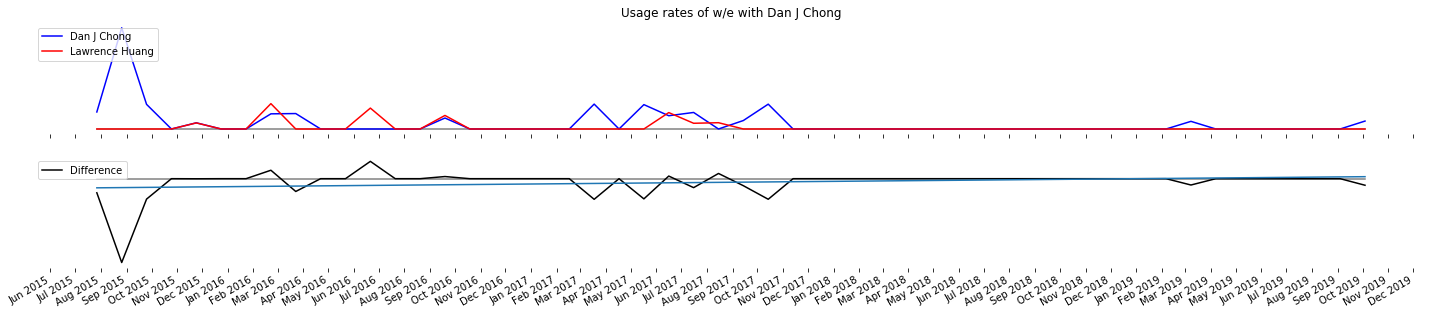

Influence score: nan
A positive influence score means you influenced the other person.
    (aka your usage rate was initially higher than the other person)

    A negative influence score the other person influenced you.
    (aka your usage rate was initially lower than the other person)


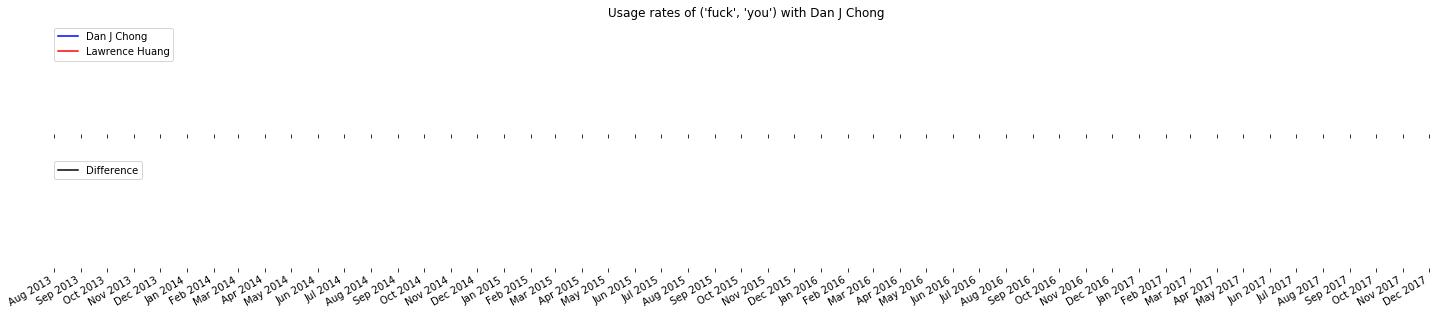

Influence score: -1.383479075580375
A positive influence score means you influenced the other person.
    (aka your usage rate was initially higher than the other person)

    A negative influence score the other person influenced you.
    (aka your usage rate was initially lower than the other person)


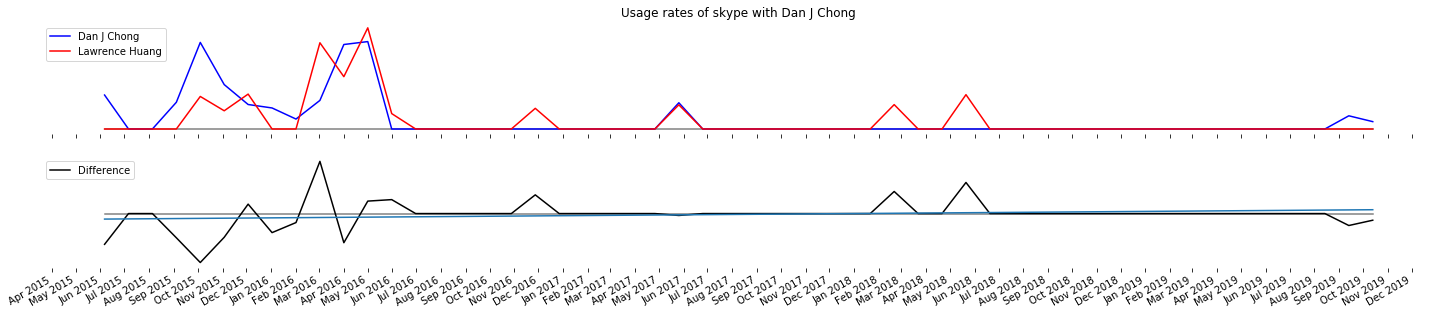

Influence score: 0.6412578169350889
A positive influence score means you influenced the other person.
    (aka your usage rate was initially higher than the other person)

    A negative influence score the other person influenced you.
    (aka your usage rate was initially lower than the other person)


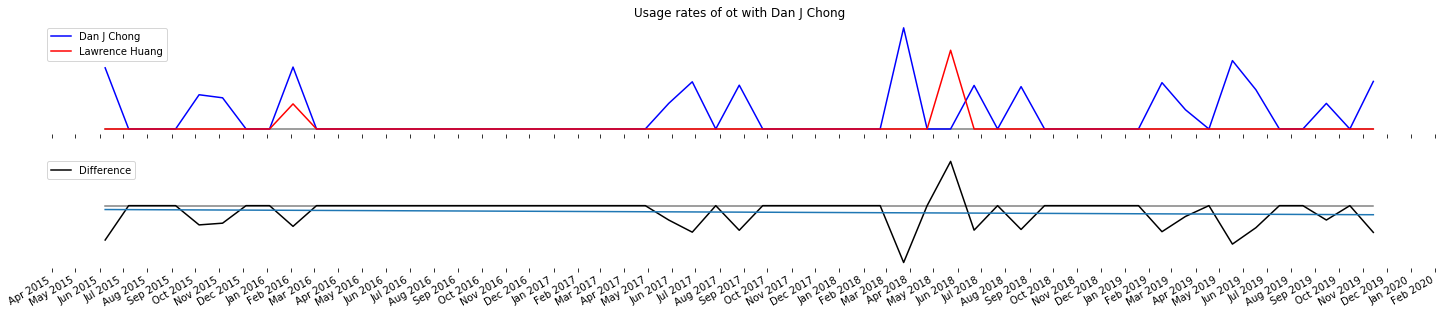

Influence score: 0.9320156828574924
A positive influence score means you influenced the other person.
    (aka your usage rate was initially higher than the other person)

    A negative influence score the other person influenced you.
    (aka your usage rate was initially lower than the other person)


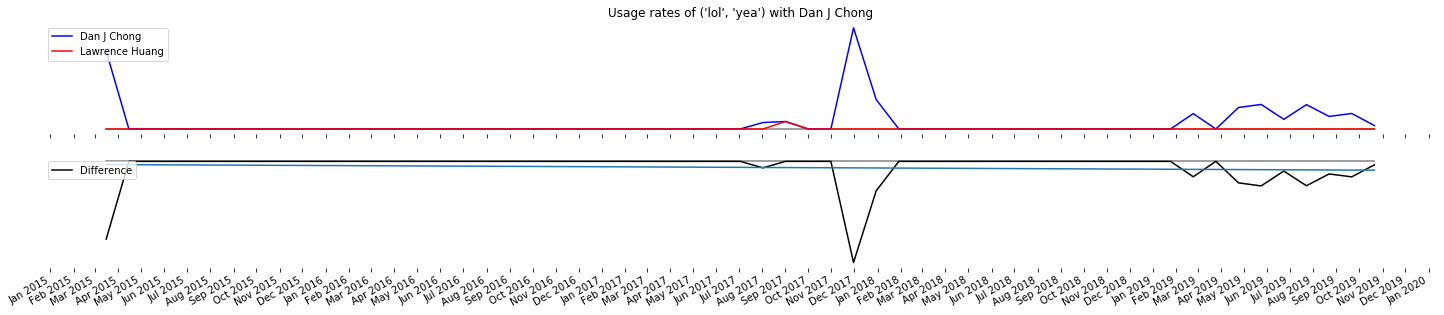

Influence score: 0.9953467303559052
A positive influence score means you influenced the other person.
    (aka your usage rate was initially higher than the other person)

    A negative influence score the other person influenced you.
    (aka your usage rate was initially lower than the other person)


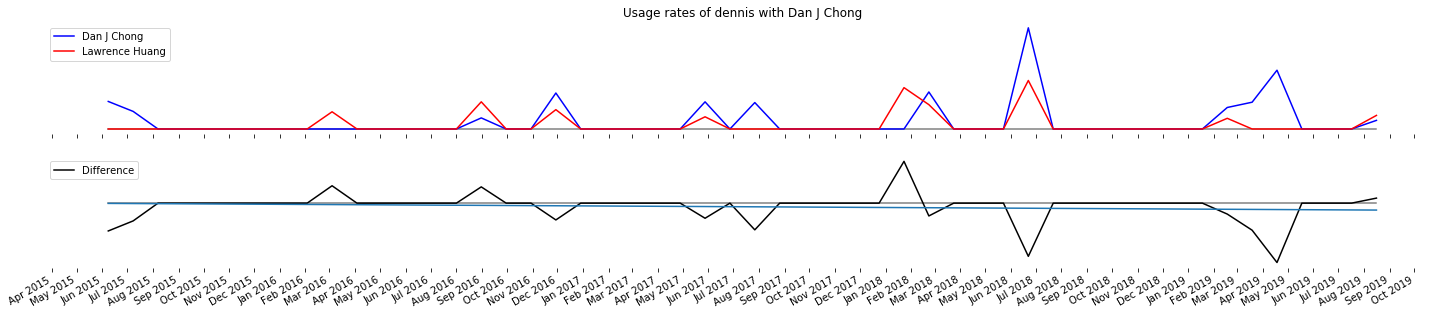

Influence score: -1.516019802658203
A positive influence score means you influenced the other person.
    (aka your usage rate was initially higher than the other person)

    A negative influence score the other person influenced you.
    (aka your usage rate was initially lower than the other person)


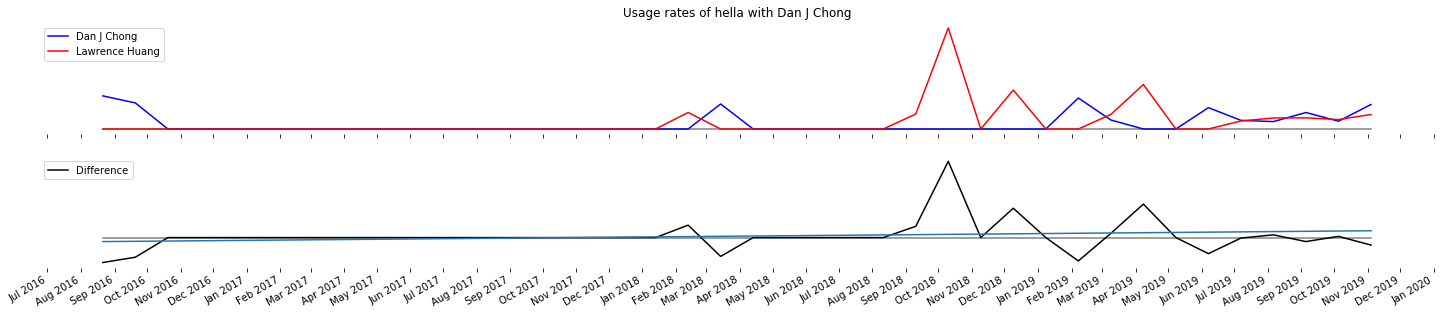

Influence score: nan
A positive influence score means you influenced the other person.
    (aka your usage rate was initially higher than the other person)

    A negative influence score the other person influenced you.
    (aka your usage rate was initially lower than the other person)


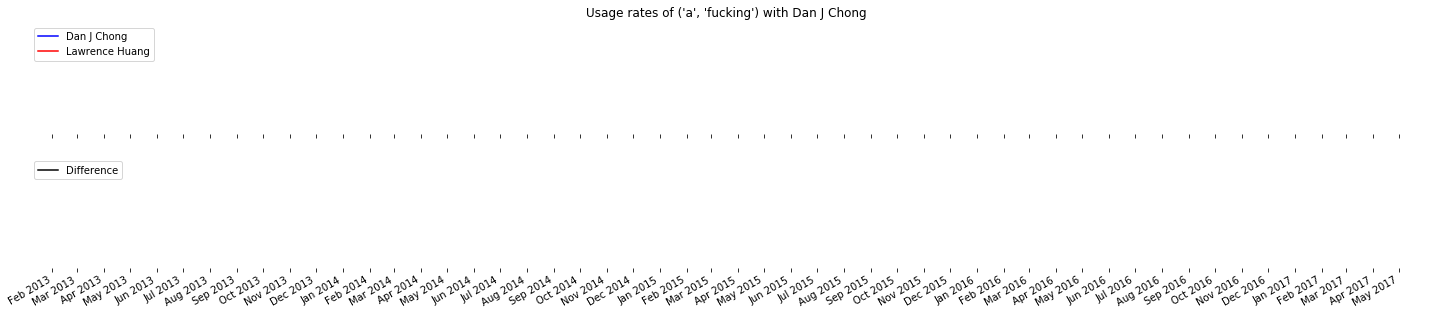

Influence score: -0.01447222168195987
A positive influence score means you influenced the other person.
    (aka your usage rate was initially higher than the other person)

    A negative influence score the other person influenced you.
    (aka your usage rate was initially lower than the other person)


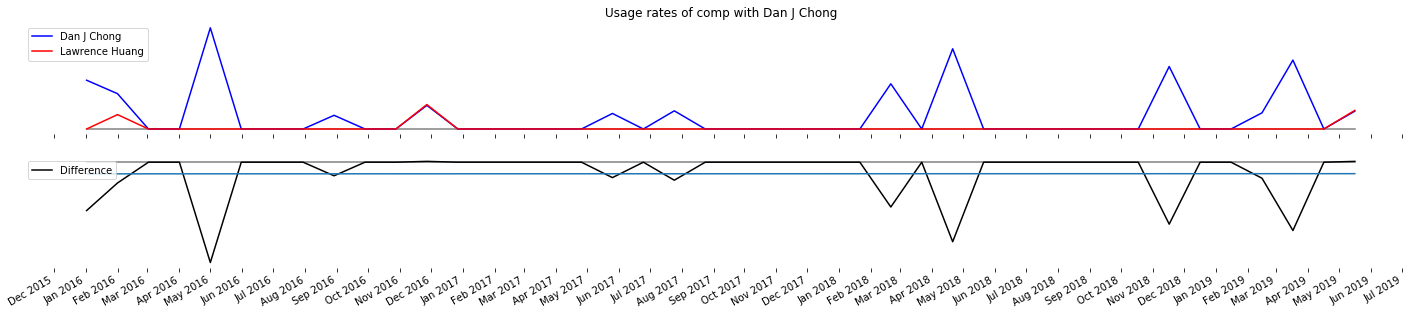

Influence score: -1.3024819333512159
A positive influence score means you influenced the other person.
    (aka your usage rate was initially higher than the other person)

    A negative influence score the other person influenced you.
    (aka your usage rate was initially lower than the other person)


In [ ]:
for TERM in freq_per_friend:
    friend_timestamps = term_to_senders[TERM][FRIEND_NAME][FRIEND_NAME]
    user_timestamps = term_to_senders[TERM][FRIEND_NAME][account_user_name]

    first_mention = None
    last_mention = None
    # no mentions
    if len(friend_timestamps) == 0 and len(user_timestamps) == 0:
        pass
    elif len(friend_timestamps) == 0:
        first_mention = user_timestamps[0]
        last_mention = user_timestamps[0]
    elif len(user_timestamps) == 0:
        first_mention = friend_timestamps[0]
        last_mention = friend_timestamps[0]
    else:
        first_mention = min(friend_timestamps[0], user_timestamps[0])
        last_mention = max(friend_timestamps[-1], user_timestamps[-1])

    if first_mention is not None and last_mention is not None:
        x_axis = []
        friend_usage_rates = []
        user_usage_rates = []

        START_MS = first_mention
        END_MS = START_MS + MILLISEC_PER_MONTH
        while START_MS <= last_mention:
            rate_dict = term_freq_avg(START_MS, END_MS, TERM, FRIEND_NAME, msg_dir)
            START_MS = END_MS
            END_MS = START_MS + MILLISEC_PER_MONTH
            x_axis.append(datetime.datetime.utcfromtimestamp(START_MS / 1000).replace(tzinfo=datetime.timezone.utc))
            friend_usage_rates.append(rate_dict[FRIEND_NAME])
            user_usage_rates.append(rate_dict[account_user_name])
    else:
        raise ValueError(f"No mentions of {TERM} found for {FRIEND_NAME}")
        
    friend_usage_rates = np.asarray(friend_usage_rates)
    user_usage_rates = np.asarray(user_usage_rates)

    # Create the base line
    start = x_axis[0]
    stop = x_axis[-1]

    fig, ax = plt.subplots(nrows=2, figsize=(25, 5))
    ax[0].plot((start, stop), (0, 0), 'k', alpha=.5)
    ax[1].plot((start, stop), (0, 0), 'k', alpha=.5)

    ax[0].set(title=f"Usage rates of {TERM} with {FRIEND_NAME}")
    ax[0].plot(x_axis, friend_usage_rates, label=f"{FRIEND_NAME}", c='b')
    ax[0].plot(x_axis, user_usage_rates, label=f"{account_user_name}", c='r')

    # difference: negative means friend influenced user
    difference = user_usage_rates - friend_usage_rates
    # difference -= min(difference)
    # make all difference values positive
    ax[1].plot(x_axis, difference, label="Difference", c='black')

    # timestamps in seconds
    x_timestamps = np.array([dt.replace(tzinfo=timezone.utc).timestamp() for dt in x_axis])

    # time range covered by data
    total_time = np.ptp(x_timestamps)
    avg_diff = np.mean(abs(difference))
    slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(x=x_timestamps, y=difference)

    # normalize the scope to calculate influence score
    influence_score = -slope * total_time / avg_diff

    # 0 slope means there was little influence
    print(f"Influence score: {influence_score}")
    print("""A positive influence score means you influenced the other person.
    (aka your usage rate was initially higher than the other person)

    A negative influence score the other person influenced you.
    (aka your usage rate was initially lower than the other person)""")

    ax[1].plot(x_axis, intercept + slope*x_timestamps)

    for i in range(len(ax)):
        ax[i].get_xaxis().set_major_locator(mdates.MonthLocator(interval=1))
        ax[i].get_xaxis().set_major_formatter(mdates.DateFormatter("%b %Y"))
        fig.autofmt_xdate()

        plt.setp((ax[i].get_yticklabels() + ax[i].get_yticklines() +
                      list(ax[i].spines.values())), visible=False)

        ax[i].legend(loc='upper left');
    plt.show()

    # show distribution of diferences
    # plt.hist(difference)
    # plt.show()

    # TODO: implement geometric weighting for earlier difference terms